In [1]:
# dependencies
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import time
import pickle
import data_utils
import matplotlib.pyplot as plt
import re
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu

/home/padma/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/padma/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/padma/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/padma/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: Futu

In [2]:
from collections import Counter

def read_sentences(file_path):
	sentences = []

	with open(file_path, 'r') as reader:
		for s in reader:
			sentences.append(s.strip())

	return sentences

def iteritems(dic):
    return iter([(key, dic[key]) for key in dic])

def create_dataset(en_sentences, sn_sentences):

	en_vocab_dict = Counter(word.strip(',." ;:)(][?!') for sentence in en_sentences for word in sentence.split())
	sn_vocab_dict = Counter(word.strip(',." ;:)(][?!') for sentence in sn_sentences for word in sentence.split())

	en_vocab = list(map(lambda x: x[0], sorted(en_vocab_dict.items(), key = lambda x: -x[1])))
	sn_vocab = list(map(lambda x: x[0], sorted(sn_vocab_dict.items(), key = lambda x: -x[1])))

	en_vocab = en_vocab[:20000]
	sn_vocab = sn_vocab[:30000]

	start_idx = 2
	en_word2idx = dict([(word, idx+start_idx) for idx, word in enumerate(en_vocab)])
	en_word2idx['<ukn>'] = 0
	en_word2idx['<pad>'] = 1

	en_idx2word = dict([(idx, word) for word, idx in iteritems(en_word2idx)])


	start_idx = 4
	sn_word2idx = dict([(word, idx+start_idx) for idx, word in enumerate(sn_vocab)])
	sn_word2idx['<ukn>'] = 0
	sn_word2idx['<go>']  = 1
	sn_word2idx['<eos>'] = 2
	sn_word2idx['<pad>'] = 3

	sn_idx2word = dict([(idx, word) for word, idx in iteritems(sn_word2idx)])

	x = [[en_word2idx.get(word.strip(',." ;:)(][?!'), 0) for word in sentence.split()] for sentence in en_sentences]
	y = [[sn_word2idx.get(word.strip(',." ;:)(][?!'), 0) for word in sentence.split()] for sentence in sn_sentences]

	X = []
	Y = []
	for i in range(len(x)):
		n1 = len(x[i])
		n2 = len(y[i])
		n = n1 if n1 < n2 else n2 
		if abs(n1 - n2) <= 0.3 * n:
			if n1 <= 15 and n2 <= 15:
				X.append(x[i])
				Y.append(y[i])

	return X, Y, en_word2idx, en_idx2word, en_vocab, sn_word2idx, sn_idx2word, sn_vocab

def save_dataset(file_path, obj):
	with open(file_path, 'wb') as f:
		pickle.dump(obj, f, -1)

def main():
    en_sentences = read_sentences('./Data/bible.en')
    sn_sentences = read_sentences('./Data/bible.san')

    save_dataset('./Data/bible2.pkl', create_dataset(sn_sentences, en_sentences))

In [3]:
main()

In [4]:
def convert_sanskrit(uni):
    a = bytearray(uni, encoding = "utf-8").decode('unicode-escape')
    return a

In [5]:
# read dataset
def read_dataset(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f,encoding="utf_8")

X, Y, sn_word2idx, sn_idx2word, sn_vocab, en_word2idx, en_idx2word, en_vocab  = read_dataset('./Data/data.pkl')

In [6]:
#inspecting data
print('Sentence in Sanskrit - encoded:', X[0])
print('Sentence in English - encoded:', Y[0])
print('Decoded:\n------------------------')

for i in range(len(X[3])):
    print(convert_sanskrit(sn_idx2word[X[3][i]]), end = " ")
    
print('\n')

for i in range(len(Y[3])):
    print(en_idx2word[Y[3][i]], end = " ")

Sentence in Sanskrit - encoded: [688, 1181, 506, 6, 1181, 11328, 0]
Sentence in English - encoded: [5, 583, 6, 5, 462, 6, 39, 139, 0, 5, 62, 6, 333, 0, 5, 62, 6, 328, 0]
Decoded:
------------------------
तस्य पुत्रो ऽम्मीनादब् तस्य पुत्रो नहशोन् तस्य पुत्रः सल्मोन्। 

and aram begat aminadab <ukn> and aminadab begat naasson <ukn> and naasson begat salmon <ukn> 

In [7]:
print(sum([len(sentence) for sentence in X]) / len(X))
print(sum([len(sentence) for sentence in Y]) / len(Y))

11.58403468502933
21.631981637337415


In [8]:
# data processing

# data padding
def data_padding(x, y, length = 10):
    for i in range(len(x)):
        x[i] = x[i] + (length - len(x[i])) * [sn_word2idx['<pad>']]
        y[i] = [en_word2idx['<go>']] + y[i] + [en_word2idx['<eos>']] + (length-len(y[i])) * [en_word2idx['<pad>']]

data_padding(X, Y)

# data splitting
X_train,  X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1)

del X
del Y

In [9]:
input_seq_len = 10
output_seq_len = 12
sn_vocab_size = len(sn_vocab) + 2 # + <pad>, <ukn>
en_vocab_size = len(en_vocab) + 4 # + <pad>, <ukn>, <eos>, <go>

# placeholders
encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

targets = [decoder_inputs[i+1] for i in range(output_seq_len-1)]
# add one more target
targets.append(tf.placeholder(dtype = tf.int32, shape = [None], name = 'last_target'))
target_weights = [tf.placeholder(dtype = tf.float32, shape = [None], name = 'target_w{}'.format(i)) for i in range(output_seq_len)]

# output projection
size = 512
w_t = tf.get_variable('proj_w', [en_vocab_size, size], tf.float32)
b = tf.get_variable('proj_b', [en_vocab_size], tf.float32)
w = tf.transpose(w_t)
output_projection = (w, b)

outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                            encoder_inputs,
                                            decoder_inputs,
                                            tf.contrib.rnn.BasicLSTMCell(size),
                                            num_encoder_symbols = sn_vocab_size,
                                            num_decoder_symbols = en_vocab_size,
                                            embedding_size = 100,
                                            feed_previous = False,
                                            output_projection = output_projection,
                                            dtype = tf.float32)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [10]:
# define our loss function

def sampled_loss(labels, logits):
    return tf.nn.sampled_softmax_loss(
                        weights = w_t,
                        biases = b,
                        labels = tf.reshape(labels, [-1, 1]),
                        inputs = logits,
                        num_sampled = 512,
                        num_classes = en_vocab_size)

# Weighted cross-entropy loss for a sequence of logits
loss = tf.contrib.legacy_seq2seq.sequence_loss(outputs, targets, target_weights, softmax_loss_function = sampled_loss)

In [11]:
# let's define some helper functions

# simple softmax function
def softmax(x):
    n = np.max(x)
    e_x = np.exp(x - n)
    return e_x / e_x.sum()

# feed data into placeholders
def feed_dict(x, y, batch_size = 64):
    feed = {}
    
    idxes = np.random.choice(len(x), size = batch_size, replace = False)
    
    for i in range(input_seq_len):
        feed[encoder_inputs[i].name] = np.array([x[j][i] for j in idxes], dtype = np.int32)
        
    for i in range(output_seq_len):
        feed[decoder_inputs[i].name] = np.array([y[j][i] for j in idxes], dtype = np.int32)
        
    feed[targets[len(targets)-1].name] = np.full(shape = [batch_size], fill_value = en_word2idx['<pad>'], dtype = np.int32)
    
    for i in range(output_seq_len-1):
        batch_weights = np.ones(batch_size, dtype = np.float32)
        target = feed[decoder_inputs[i+1].name]
        for j in range(batch_size):
            if target[j] == en_word2idx['<pad>']:
                batch_weights[j] = 0.0
        feed[target_weights[i].name] = batch_weights
        
    feed[target_weights[output_seq_len-1].name] = np.zeros(batch_size, dtype = np.float32)
    
    return feed

# decode output sequence
def decode_output(output_seq):
    words = []
    for i in range(output_seq_len):
        smax = softmax(output_seq[i])
        idx = np.argmax(smax)
        words.append(sn_idx2word[idx])
    return words

In [12]:
saver = tf.train.Saver()

In [13]:
# ops and hyperparameters
learning_rate = 0.002
batch_size = 512
steps = 5000

# ops for projecting outputs
outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]

# training op
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

# init op
init = tf.global_variables_initializer()

# forward step
def forward_step(sess, feed):
    output_sequences = sess.run(outputs_proj, feed_dict = feed)
    return output_sequences

# training step
def backward_step(sess, feed):
    sess.run(optimizer, feed_dict = feed)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
# we will use this list to plot losses through steps
losses = []

In [15]:
# let's train the model

# save a checkpoint so we can restore the model later 

checkpointsPath = './checkpoints501previous/'
restore = False
starting_step = 0

print('------------------TRAINING------------------')
with tf.Session() as sess:
    if (restore):
        print('Restoring')
        with open(checkpointsPath + 'checkpoint') as f:
            starting_step = int(re.match('model_checkpoint_path: "-([0-9]+)"', list(f)[0]).groups()[0]) + 1
        saver.restore(sess, tf.train.latest_checkpoint(checkpointsPath))
        print('Running from step {}'.format(starting_step))
    else:
        print('Running from scratch: generating random model parameters.')
        sess.run(init)
    
    t = time.time()
    for step in range(starting_step, starting_step + steps):
        feed = feed_dict(X_train, Y_train)
            
        backward_step(sess, feed)
        
        if step % 5 == 4 or step == 0:
            loss_value = sess.run(loss, feed_dict = feed)
            print('step: {}, loss: {}'.format(step, loss_value))
            losses.append(loss_value)
        
        if step % 20 == 19:
            saver.save(sess, checkpointsPath, global_step=step)
            print('Checkpoint is saved')
            
    print('Training time for {} steps: {}s'.format(steps, time.time() - t))

------------------TRAINING------------------
Running from scratch: generating random model parameters.
step: 0, loss: 8.333747863769531
step: 4, loss: 8.232805252075195
step: 9, loss: 8.312421798706055
step: 14, loss: 8.269936561584473
step: 19, loss: 8.219232559204102
Checkpoint is saved
step: 24, loss: 8.296436309814453
step: 29, loss: 8.272409439086914
step: 34, loss: 8.297248840332031
step: 39, loss: 8.192925453186035
Checkpoint is saved
step: 44, loss: 8.22457218170166
step: 49, loss: 8.28042984008789
step: 54, loss: 8.278844833374023
step: 59, loss: 8.21043586730957
Checkpoint is saved
step: 64, loss: 8.272994995117188
step: 69, loss: 8.192564964294434
step: 74, loss: 8.17745590209961
step: 79, loss: 8.148529052734375
Checkpoint is saved
step: 84, loss: 8.17813491821289
step: 89, loss: 8.035867691040039
step: 94, loss: 7.125682353973389
step: 99, loss: 6.453903675079346
Checkpoint is saved
step: 104, loss: 6.130676746368408
step: 109, loss: 5.529538154602051
step: 114, loss: 5.42

step: 959, loss: 0.2601716220378876
Checkpoint is saved
step: 964, loss: 0.20920909941196442
step: 969, loss: 0.2004820555448532
step: 974, loss: 0.1597505807876587
step: 979, loss: 0.2361387312412262
Checkpoint is saved
step: 984, loss: 0.17753468453884125
step: 989, loss: 0.1695575714111328
step: 994, loss: 0.17660875618457794
step: 999, loss: 0.27392691373825073
Checkpoint is saved
step: 1004, loss: 0.21980778872966766
step: 1009, loss: 0.14295178651809692
step: 1014, loss: 0.14556890726089478
step: 1019, loss: 0.12024401128292084
Checkpoint is saved
step: 1024, loss: 0.1540902853012085
step: 1029, loss: 0.24274533987045288
step: 1034, loss: 0.13356004655361176
step: 1039, loss: 0.08963032066822052
Checkpoint is saved
step: 1044, loss: 0.18014857172966003
step: 1049, loss: 0.10712254047393799
step: 1054, loss: 0.14820757508277893
step: 1059, loss: 0.12535187602043152
Checkpoint is saved
step: 1064, loss: 0.15599997341632843
step: 1069, loss: 0.1291242241859436
step: 1074, loss: 0.17

step: 1919, loss: 0.029687510803341866
Checkpoint is saved
step: 1924, loss: 0.08156140148639679
step: 1929, loss: 0.0978391021490097
step: 1934, loss: 0.0379166305065155
step: 1939, loss: 0.10785579681396484
Checkpoint is saved
step: 1944, loss: 0.05735451355576515
step: 1949, loss: 0.08186864852905273
step: 1954, loss: 0.059716109186410904
step: 1959, loss: 0.10999841243028641
Checkpoint is saved
step: 1964, loss: 0.049722395837306976
step: 1969, loss: 0.06877069175243378
step: 1974, loss: 0.04537232965230942
step: 1979, loss: 0.04448793828487396
Checkpoint is saved
step: 1984, loss: 0.07496747374534607
step: 1989, loss: 0.023945175111293793
step: 1994, loss: 0.07132445275783539
step: 1999, loss: 0.03576450049877167
Checkpoint is saved
step: 2004, loss: 0.11893859505653381
step: 2009, loss: 0.1190643161535263
step: 2014, loss: 0.06538457423448563
step: 2019, loss: 0.04914434999227524
Checkpoint is saved
step: 2024, loss: 0.09587587416172028
step: 2029, loss: 0.04108016937971115
step:

step: 2869, loss: 0.04216865450143814
step: 2874, loss: 0.037519484758377075
step: 2879, loss: 0.051344387233257294
Checkpoint is saved
step: 2884, loss: 0.032823823392391205
step: 2889, loss: 0.023324891924858093
step: 2894, loss: 0.04393784701824188
step: 2899, loss: 0.0732201561331749
Checkpoint is saved
step: 2904, loss: 0.03988782316446304
step: 2909, loss: 0.03266117721796036
step: 2914, loss: 0.05643678456544876
step: 2919, loss: 0.03490963205695152
Checkpoint is saved
step: 2924, loss: 0.02002127841114998
step: 2929, loss: 0.0951865166425705
step: 2934, loss: 0.03701164200901985
step: 2939, loss: 0.03613369166851044
Checkpoint is saved
step: 2944, loss: 0.0775941014289856
step: 2949, loss: 0.058589477092027664
step: 2954, loss: 0.06733301281929016
step: 2959, loss: 0.032661519944667816
Checkpoint is saved
step: 2964, loss: 0.03276702016592026
step: 2969, loss: 0.03524468094110489
step: 2974, loss: 0.04447482153773308
step: 2979, loss: 0.019856691360473633
Checkpoint is saved
st

step: 3819, loss: 0.05517686903476715
Checkpoint is saved
step: 3824, loss: 0.0362154021859169
step: 3829, loss: 0.026152748614549637
step: 3834, loss: 0.0555746890604496
step: 3839, loss: 0.054471760988235474
Checkpoint is saved
step: 3844, loss: 0.03798111528158188
step: 3849, loss: 0.03636894375085831
step: 3854, loss: 0.020562734454870224
step: 3859, loss: 0.04779749736189842
Checkpoint is saved
step: 3864, loss: 0.0604393407702446
step: 3869, loss: 0.047137778252363205
step: 3874, loss: 0.04974457994103432
step: 3879, loss: 0.05952400714159012
Checkpoint is saved
step: 3884, loss: 0.024840090423822403
step: 3889, loss: 0.020029863342642784
step: 3894, loss: 0.024513280019164085
step: 3899, loss: 0.009491443634033203
Checkpoint is saved
step: 3904, loss: 0.03618110343813896
step: 3909, loss: 0.021576784551143646
step: 3914, loss: 0.014349689707159996
step: 3919, loss: 0.1111767515540123
Checkpoint is saved
step: 3924, loss: 0.01778746396303177
step: 3929, loss: 0.007778599392622709

Checkpoint is saved
step: 4764, loss: 0.016404809430241585
step: 4769, loss: 0.00808277539908886
step: 4774, loss: 0.07732445001602173
step: 4779, loss: 0.04449790343642235
Checkpoint is saved
step: 4784, loss: 0.01684161275625229
step: 4789, loss: 0.02919844351708889
step: 4794, loss: 0.004889690317213535
step: 4799, loss: 0.024113262072205544
Checkpoint is saved
step: 4804, loss: 0.010128558613359928
step: 4809, loss: 0.02321653999388218
step: 4814, loss: 0.04513262212276459
step: 4819, loss: 0.09035050123929977
Checkpoint is saved
step: 4824, loss: 0.0057532405480742455
step: 4829, loss: 0.09934330731630325
step: 4834, loss: 0.04940974712371826
step: 4839, loss: 0.018902651965618134
Checkpoint is saved
step: 4844, loss: 0.03596767410635948
step: 4849, loss: 0.04158840328454971
step: 4854, loss: 0.013477426953613758
step: 4859, loss: 0.019263727590441704
Checkpoint is saved
step: 4864, loss: 0.035827938467264175
step: 4869, loss: 0.015805428847670555
step: 4874, loss: 0.0069228224456

In [16]:
#tf.restore()

AttributeError: module 'tensorflow' has no attribute 'restore'

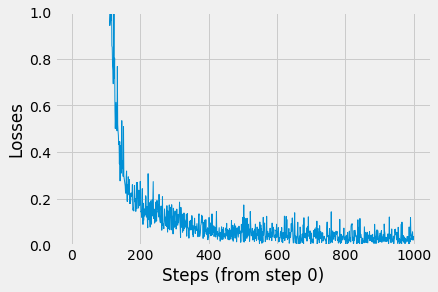

In [17]:
# plot losses

with plt.style.context('fivethirtyeight'):
    plt.plot(losses, linewidth = 1)
    plt.xlabel('Steps (from step {})'.format(starting_step))
    plt.ylabel('Losses')
    plt.ylim((0, 1))

plt.show()

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
f = pd.DataFrame(columns=['Translation', 'Expected', 'Bleu_Score'])

with tf.Graph().as_default():
    
    # placeholders
    encoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'encoder{}'.format(i)) for i in range(input_seq_len)]
    decoder_inputs = [tf.placeholder(dtype = tf.int32, shape = [None], name = 'decoder{}'.format(i)) for i in range(output_seq_len)]

    # output projection
    size = 512
    w_t = tf.get_variable('proj_w', [en_vocab_size, size], tf.float32)
    b = tf.get_variable('proj_b', [en_vocab_size], tf.float32)
    w = tf.transpose(w_t)
    output_projection = (w, b)
    
    # change the model so that output at time t can be fed as input at time t+1
    outputs, states = tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                                                encoder_inputs,
                                                decoder_inputs,
                                                tf.contrib.rnn.BasicLSTMCell(size),
                                                num_encoder_symbols = sn_vocab_size,
                                                num_decoder_symbols = en_vocab_size,
                                                embedding_size = 100,
                                                feed_previous = True, # <-----this is changed----->
                                                output_projection = output_projection,
                                                dtype = tf.float32)
    
    # ops for projecting outputs
    outputs_proj = [tf.matmul(outputs[i], output_projection[0]) + output_projection[1] for i in range(output_seq_len)]
    df={}
    sn_sentences_encoded = X_train
    en_sentences_encoded = Y_train
    sn_sentences_extra = []#'तर्हि मम वाक्यानि कथं प्रत्येष्यथ', 'मानव इव कोपि कदापि नोपादिशत्']
    en_sentences_extra = []#'how shall ye believe my words', 'Never man spake like this man']
    sn_sentences_encoded += [[sn_word2idx[word] if word in sn_word2idx else sn_word2idx['<ukn>'] for word in sentence.encode('unicode-escape').decode('utf-8').split()] for sentence in sn_sentences_extra]
    en_sentences_encoded += [[en_word2idx[word] if word in en_word2idx else en_word2idx['<ukn>'] for word in sentence.split()] for sentence in en_sentences_extra]
    # padding to fit encoder input
    for i in range(len(sn_sentences_encoded)):
        sn_sentences_encoded[i] += (15 - len(sn_sentences_encoded[i])) * [sn_word2idx['<pad>']]
    for i in range(len(en_sentences_encoded)):
        en_sentences_encoded[i] += (15 - len(en_sentences_encoded[i])) * [en_word2idx['<pad>']]
    
    # restore all variables - use the last checkpoint saved
    saver = tf.train.Saver()
    path = tf.train.latest_checkpoint(checkpointsPath)
    
    with tf.Session() as sess:
        # restore
        saver.restore(sess, path)
        
        # feed data into placeholders
        feed = {}
        for i in range(input_seq_len):
            feed[encoder_inputs[i].name] = np.array([sn_sentences_encoded[j][i] for j in range(len(sn_sentences_encoded))], dtype = np.int32)
            
        feed[decoder_inputs[0].name] = np.array([en_word2idx['<go>']] * len(sn_sentences_encoded), dtype = np.int32)
        
        # translate
        output_sequences = sess.run(outputs_proj, feed_dict = feed)
        
        # decode seq.
        for i in range(len(sn_sentences_encoded)):
            print('{}.\n--------------------------------'.format(i+1))
            ouput_seq = [output_sequences[j][i] for j in range(output_seq_len)]
            #decode output sequence
            words = decode_output(ouput_seq)
            expected = [en_idx2word[word] for word in en_sentences_encoded[i]]
        
            print(" ". join([convert_sanskrit(sn_idx2word[word]) for word in sn_sentences_encoded[i] if word is not sn_word2idx['<pad>']]))
            #print(" ". join([(en_idx2word[word]) for word in en_sentences_encoded[i]]))
            
            translation_bleu = []
            print('Translated: ', end = " ")
            for j in range(len(words)):
                if words[j] not in ['<eos>', '<pad>', '<go>']:
                    print((words[j]), end = " ")
                    translation_bleu.append(words[j])
            print()
            expected_bleu = []
            print('  Expected: ', end = " ")
            for j in range(len(expected)):
                if expected[j] not in ['<eos>', '<pad>', '<go>']:
                    print(expected[j], end = " ")
                    expected_bleu.append(expected[j])
            print()
            
            bleu_score = sentence_bleu([expected_bleu], translation_bleu)
            #df+=" Translation = "+ translation_bleu + " Expected = " + expected_bleu + " Bleu_ score = " +bleu_score
           # df = df.append(other = {'Translation':translation_bleu, 'Expected':expected_bleu, 'Bleu_Score':bleu_score},ignore_index=True)
            print('Bleu Score: ', end = " ")
            print(bleu_score)

            print('\n--------------------------------')

INFO:tensorflow:Restoring parameters from ./checkpoints501previous/-4999
1.
--------------------------------
इतरेऽकथयन् तिष्ठत <ukn> तं रक्षितुम् एलिय आयाति नवेति पश्यामः।
Translated:  \u091a \u092a\u093e\u092a\u0902 \u092e\u093e\u0902 <ukn> \u092f\u0941\u0937\u094d\u092e\u093e\u0928\u0939\u0902 \u092f\u0926\u093f <ukn> \u092f\u0941\u0937\u094d\u092e\u093e\u0928\u0939\u0902 \u092f\u0926\u093e \u0905\u0938\u094d\u092e\u093e\u0915\u0902 \u0915\u0925\u092f\u093f\u0924\u0941\u0902 <ukn> 
  Expected:  the rest said <ukn> let be <ukn> let us see whether elias will come to save him <ukn> 
Bleu Score:  7.813508425061864e-232

--------------------------------
2.
--------------------------------
यदि मनुष्यस्येति वदामस्तर्हि सर्व्वे लोका अस्मान् पाषाणै <ukn> यतो योहन् भविष्यद्वादीति सर्व्वे दृढं जानन्ति।
Translated:  \u092f\u094b \u0915\u093f\u0928\u094d\u0924\u0941 \u092e\u0927\u094d\u092f\u0947 \u0924\u0926\u093e\u0928\u0940\u0902 \u0938\u0928\u094d <ukn> \u0924\u0938\u094d\u092f \u091c\u0928\u

ते स्वान् ज्ञानिनो ज्ञात्वा ज्ञानहीना अभवन्
Translated:  \u0928\u093f\u092f\u0941\u091c\u094d\u092f \u091c\u0928 \u0924\u0926\u093e \u092f\u0926\u093f \u0915\u093f\u091e\u094d\u091a <ukn> \u092e\u092e \u0936\u094d\u092e\u0936\u093e\u0928\u093e\u0924\u094d \u0928\u093f\u092f\u0941\u0915\u094d\u0924\u0903 <ukn> \u0938 \u0924\u093e\u0902 
  Expected:  professing themselves to be wise <ukn> they became fools <ukn> 
Bleu Score:  1.1640469867513693e-231

--------------------------------
12.
--------------------------------
तदा पितरस्तं गदितवान् <ukn> पश्य <ukn> वयं सर्व्वं परित्यज्य भवतः पश्चाद्वर्त्तिनो ऽभवाम <ukn> वयं किं प्राप्स्यामः <ukn>
Translated:  \u0908\u0936\u094d\u0935\u0930\u0938\u094d\u092f \u092f\u0938\u094d\u092f \u0924\u0941 \u0915\u093f\u0928\u094d\u0924\u0941 \u092e\u093e\u0902 \u092f\u0942\u092f\u0902 \u0939\u0947 <ukn> \u0935\u093f\u0932\u094b\u0915\u094d\u092f <ukn> \u0924\u0926\u093e\u0928\u0940\u0902 \u0924\u092e\u094d 
  Expected:  then answered peter and said unto hi

प्रथमतो ये साक्षिणो वाक्यप्रचारकाश्चासन् <ukn> मध्ये यद्यत् सप्रमाणं वाक्यमर्पयन्ति स्म
Translated:  \u0935\u0915\u094d\u0924\u0935\u094d\u092f\u0902 \u0924\u0924\u094d \u090f\u0915\u094b \u092f\u0903 \u092a\u0930\u092e\u0947\u0936\u094d\u0935\u0930\u0938\u094d\u092f \u0924\u0902 \u092c\u092d\u093e\u0937\u0947 \u0924\u0926\u093e \u092a\u0930\u092e\u094d \u092f\u0947\u0928 \u0924\u0902 \u092a\u0936\u094d\u092f\u0947\u0924\u093f 
  Expected:  forasmuch as many have taken in hand to set forth in order a declaration of those things which are most surely believed among us <ukn> 
Bleu Score:  0

--------------------------------
26.
--------------------------------
यथोक्तवान् तथा स्वस्य दायूदः सेवकस्य तु।
Translated:  \u0924\u0924\u0903 \u0924\u0947 \u0907\u092e\u093e\u0902 \u090f\u0932\u093f\u092f\u0903 \u092f\u0942\u092f\u0902 \u092f\u0926\u093e <ukn> \u0924\u0924\u0903 \u0924\u0926\u093e\u0928\u0940\u0902 \u0938\u0930\u094d\u0935\u094d\u0935\u0947\u0937\u093e\u0902 \u092a\u0935\u093f\u0924

सञ्जय उवाच ।दृष्ट्वा तु <ukn> व्यूढं दुर्योधनस्तदा ।आचार्यमुपसङ्गम्य राजा वचनमब्रवीत् ।। ।।
Translated:  \u092e\u0928\u0941\u0937\u094d\u092f\u093e \u092e\u093e\u0902 <ukn> \u0935\u092f\u0902 \u0928\u094b\u0939\u094b \u091a \u0915\u093f\u092e\u0947\u0924\u0926\u094d \u0907\u0924\u094d\u092f\u092a\u093f \u0928\u0948\u0935 \u0924\u0902 \u091c\u093e\u0928\u0941\u092a\u093e\u0924\u0902 <ukn> 
  Expected:  sanjay said <ukn> on observing the pandava army standing in military formation <ukn> king duryodhan approached his teacher dronacharya <ukn> and said the following words <ukn> 
Bleu Score:  3.624879844624495e-232

--------------------------------
39.
--------------------------------
यतस्ते यथास्मान् विना सिद्धा न <ukn> कृते श्रेष्ठतरं किमपि निर्दिदिशे।
Translated:  \u092f\u0924\u094b \u0926\u094d\u0935\u094c \u092a\u0932\u093e\u092f\u0928\u094d\u0924\u093e\u0902 \u0938\u093e\u0915\u094d\u0937\u093e\u0924\u094d \u092f\u0940\u0936\u0941\u0938\u094d\u0924\u093e\u0928\u094d \u0907\u0924\u094d

तत्रोभयपादयोश्चलनशक्तिहीनो जन्मारभ्य खञ्जः कदापि गमनं नाकरोत् एतादृश एको मानुषो लुस्त्रानगर उपविश्य पौलस्य कथां श्रुतवान्।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092e\u092f\u093e \u0938\u0941\u0938\u0902\u0935\u093e\u0926\u0902 \u092f\u0941\u0937\u094d\u092e\u093e\u0915\u0902 \u0915\u0936\u094d\u091a\u093f\u0926\u094d \u0915\u0943\u0924\u094d\u0935\u093e \u0915\u094b\u092a\u093f \u0918\u0943\u0924\u094d\u0935\u093e <ukn> \u092a\u094b\u0924\u0947 \u0924\u0902 \u091c\u0928\u094b 
  Expected:  and there sat a certain man at lystra <ukn> impotent in his feet <ukn> being a cripple from his mother ' s womb <ukn> who never had walked <ukn> 
Bleu Score:  2.3739004130723252e-232

--------------------------------
52.
--------------------------------
कैसरराजाय करोस्माभि र्देयो न वा <ukn>
Translated:  \u0915\u093f\u0902 \u092f\u0947 \u0915\u0943\u0924\u0902 \u0907\u0924\u093f \u092f\u0926\u093e \u0924\u0926\u093e \u091c\u0928\u093e \u092a\u094d\u0930\u093e\u092a\u094d\u0938\u094d\u092

किनानीयः शिमोन् <ukn> य ईष्करियोतीययिहूदाः ख्रीष्टं <ukn>
Translated:  \u092f\u0941\u0937\u094d\u092e\u092d\u094d\u092f\u0902 \u091a \u0909\u0924\u094d\u0924\u092e\u0902 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u0915\u093e\u0930\u093e\u092f\u093e\u0902 \u0905\u092a\u0943\u091a\u094d\u091b\u0924\u094d <ukn> \u0905\u092a\u0930\u091e\u094d\u091a \u0938\u0924\u093f \u092e\u0928\u094d\u0926\u093f\u0930\u0902 \u0939\u0947 
  Expected:  simon the canaanite <ukn> and judas iscariot <ukn> who also betrayed him <ukn> 
Bleu Score:  1.0709749285266912e-231

--------------------------------
65.
--------------------------------
एषा कथा समस्तयाफोनगरं व्याप्ता तस्माद् अनेके लोकाः प्रभौ व्यश्वसन्।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092f\u0947 \u092f\u0925\u093e \u0915\u094c\u0928\u094d\u0924\u0947\u092f \u0924\u0924\u094d\u092a\u0936\u094d\u091a\u093e\u0926\u094d \u0915\u0925\u093e\u0902 \u0924\u0948\u0932\u0902 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u090f\u0915\u094b \u092a\u0

किन्तु तेषां <ukn> र्जनोयं बालसिबूबा अर्थाद् <ukn> भूतान् त्याजयति।
Translated:  \u092f\u094b \u0938\u093e\u0915\u094d\u0937\u093e\u0924\u094d \u0924\u0938\u094d\u092f \u0924\u0947\u0937\u093e\u0902 \u092e\u093e\u0902 <ukn> \u0924\u0947 \u092a\u0930\u093f\u092a\u0942\u0930\u094d\u0923\u0902 \u0938\u0939 \u092e\u0928\u094d\u0926\u093f\u0930\u0938\u094d\u092f \u0924\u0926\u0928\u0928\u094d\u0924\u0930\u0902 \u0938\u093e\u0915\u094d\u0937\u093e\u0924\u094d 
  Expected:  but some of them said <ukn> he casteth out devils through beelzebub the chief of the devils <ukn> 
Bleu Score:  5.9369825315016335e-232

--------------------------------
78.
--------------------------------
तदा यीशुः कथितवान् अहमेव उत्थापयिता जीवयिता च यः कश्चन मयि विश्वसिति स मृत्वापि जीविष्यति <ukn>
Translated:  \u0924\u0938\u094d\u092e\u093e\u0924\u094d \u092e\u093e\u0902 \u092f\u0942\u092f\u0902 \u091a\u0964 <ukn> \u0924\u0930\u094d\u0939\u093f \u0915\u0936\u094d\u091a\u093f\u0924\u094d \u091a \u0938\u0928\u094d\u0924\

मित्राणां कारणात् स्वप्राणदानपर्य्यन्तं यत् प्रेम तस्मान् महाप्रेम कस्यापि नास्ति।
Translated:  \u0915\u0941\u0930\u0941\u0925 \u0915\u0930\u094d\u092e \u092f\u0924\u0903 \u0915\u093f\u092e\u092a\u093f \u0915\u0943\u0924\u094d\u0935\u093e \u0909\u0924\u094d\u0925\u093e\u092f \u092a\u094d\u0930\u0924\u093f <ukn> \u0924\u0924\u0903 \u092f\u0941\u0937\u094d\u092e\u093e\u0915\u0902 \u0915\u0943\u0924\u094d\u0935\u093e \u0915\u093f\u0902 
  Expected:  greater love hath no man than this <ukn> that a man lay down his life for his friends <ukn> 
Bleu Score:  5.4622876178599384e-232

--------------------------------
91.
--------------------------------
तदा यीशुरकथयद् आश्चर्य्यं कर्म्म चित्रं चिह्नं च न दृष्टा यूयं न प्रत्येष्यथ।
Translated:  \u0908\u0936\u094d\u0935\u0930\u0938\u094d\u092f \u092e\u093e\u0902 \u0924\u0938\u094d\u092e\u093e\u0924\u094d \u092f\u0942\u092f\u0902 \u0939\u0947 <ukn> \u0926\u0926\u093e\u0924\u093f \u0924\u093e\u0928\u094d \u0905\u0938\u094d\u092e\u093e\u0915\u0902 \u0

तदा ते कथितवन्तस्तर्हि तस्य दूतो भवेत्।
Translated:  \u092f\u094b \u0924\u0941 \u092a\u094c\u0932\u0938\u094d\u092f \u092a\u0943\u0925\u0917\u094d <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u092a\u0930\u0902 \u092e\u092e \u0924\u0938\u094d\u092e\u093f\u0928\u094d \u0915\u0947\u0928 \u091a \u0928\u093e\u0938\u094d\u0924\u093f\u0964 
  Expected:  but peter continued knocking <ukn> and when they had opened the door <ukn> and saw him <ukn> they were astonished <ukn> 
Bleu Score:  4.623726644614724e-232

--------------------------------
108.
--------------------------------
ततः स तान् पप्रच्छ युष्माकं कति पूपाः सन्ति <ukn> तेऽकथयन् सप्त।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0947 \u0905\u0939\u092e\u094d \u0924\u0947\u0937\u093e\u0902 <ukn> \u0924\u0926\u0930\u094d\u0925\u0902 \u090f\u0915\u094b \u092a\u0925\u093f \u092f\u0903 \u0924\u093e\u0928\u094d <ukn> \u0924\u0926\u0930\u094d\u0925\u0902 
  Expected:  and he asked them <ukn> how many loaves have ye <ukn> and they 

<ukn> तु कर्माणि सङ्गं त्यक्त्वा फलानि च <ukn> कर्तव्यानीति मे पार्थ निश्चितं मतमुत्तमम् <ukn> <ukn>
Translated:  \u0936\u094d\u0930\u0941\u0924\u094d\u0935\u093e \u0915\u093f\u091e\u094d\u091a\u093f\u0924\u094d \u0938\u092a\u094d\u0924 \u092f\u0926\u093f \u0905\u0928\u094d\u092f\u091e\u094d\u091a \u0924\u093e\u0928\u093f \u092f\u094b\u0917\u094d\u092f\u094b\u0938\u094d\u092e\u093f \u0915\u093f\u0928\u094d\u0924\u0941 \u092f\u094b\u0917\u094d\u092f\u094b\u0938\u094d\u092e\u093f \u0907\u0924\u093f \u0924\u0938\u094d\u092e\u093e \u092f\u094b\u0917\u094d\u092f\u094b\u0938\u094d\u092e\u093f 
  Expected:  these activities must be performed without attachment and expectation for rewards <ukn> this is my definite and supreme verdict <ukn> o arjun <ukn> 
Bleu Score:  0

--------------------------------
121.
--------------------------------
अतएव ते सर्व्वे ऽन्यायो <ukn> दुष्टत्वं लोभो जिघांसा ईर्ष्या वधो विवादश्चातुरी कुमतिरित्यादिभि र्दुष्कर्म्मभिः परिपूर्णाः सन्तः
Translated:  \u0938\u0930\u0

पुनः कथयामास <ukn> ईश्वरस्य राज्यं कस्य सदृशं वदिष्यामि <ukn> यत् किण्वं काचित् स्त्री गृहीत्वा द्रोणत्रयपरिमितगोधूमचूर्णेषु स्थापयामास <ukn>
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092a\u0936\u094d\u091a\u093e\u0926\u094d \u0924\u0947 \u092e\u093e\u0902 \u0924\u0947 \u0924\u0947\u0937\u093e\u0902 <ukn> \u092a\u094d\u0930\u0924\u094d\u092f\u0935\u0926\u0926\u094d \u092d\u0942\u0924\u094d\u0935\u093e \u0924\u0947 <ukn> \u091a 
  Expected:  and again he said <ukn> whereunto shall i liken the kingdom of god <ukn> 
Bleu Score:  9.853445011990208e-232

--------------------------------
135.
--------------------------------
अपरं यीशुना सार्द्धं गालील आगता योषितः पश्चादित्वा श्मशाने तत्र यथा वपुः स्थापितं तच्च दृष्ट्वा
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u091a \u0928\u0930\u0902 \u0938\u0924\u093f <ukn> \u0924\u0925\u093e \u0938\u093e \u0924\u0935 \u0939\u0947 \u0938\u0930\u094d\u0935\u094d\u0935\u0947 \u0915\u0925\u092f\u093e\u092e\u093e\u0938\u0941\u0903 <ukn> 
  E

<ukn> यिहूदीयानां राजासि तर्हि स्वं रक्ष।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092d\u0935\u0924\u093f <ukn> \u092e\u0927\u094d\u092f\u0947 \u0905\u0928\u0928\u094d\u0924\u0930\u0902 \u092f\u0926\u093f \u091a \u092f\u0924 \u0924\u0938\u094d\u092f \u091a \u0938\u094d\u0925\u093e\u0928\u0947 \u0924\u0938\u094d\u092f 
  Expected:  and saying <ukn> if thou be the king of the jews <ukn> save thyself <ukn> 
Bleu Score:  7.623236468879228e-232

--------------------------------
148.
--------------------------------
तस्य वामदक्षिणयो र्द्वौ चौरौ क्रुशयो र्विविधाते।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0935 \u0939\u0947 \u092e\u092e \u091c\u0932\u0947 \u0915\u0926\u093e\u092a\u093f \u0917\u0924\u0903\u0964 <ukn> \u091a \u092f\u0940\u0936\u0941\u0903 \u0935\u092f\u0902 \u091a 
  Expected:  and with him they crucify two thieves <ukn> the one on his right hand <ukn> and the other on his left <ukn> 
Bleu Score:  4.254033874150559e-232

------------------------------

हे परिश्रान्ता भाराक्रान्ताश्च लोका यूयं <ukn> आगच्छत <ukn> अहं युष्मान् विश्रमयिष्यामि।
Translated:  \u092e\u093e \u092f\u0942\u092f\u0902 \u092f\u0941\u0937\u094d\u092e\u093e\u0928\u094d <ukn> \u0915\u0925\u093e\u0902 \u0924\u093e\u0928\u094d \u0924\u0924\u0903 \u091a\u093f\u0928\u094d\u0924\u092f\u093f\u0924\u094d\u0935\u093e \u0915\u093f\u0928\u094d\u0924\u0941 \u0935\u093e \u092a\u094d\u0930\u093e\u092a\u094d\u0938\u094d\u092f\u0938\u093f \u092a\u094d\u0930\u093e\u092a\u094d\u0938\u094d\u092f\u0938\u093f 
  Expected:  come unto me <ukn> all ye that labour and are heavy laden <ukn> and i will give you rest <ukn> 
Bleu Score:  5.025547213910947e-232

--------------------------------
164.
--------------------------------
अपरञ्च निजनयने या नासा विद्यते <ukn> ताम् अनालोच्य तव सहजस्य लोचने यत् <ukn> आस्ते <ukn> तदेव कुतो वीक्षसे <ukn>
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092f\u0938\u094d\u092e\u093e\u0924\u094d \u0938\u093f\u0916\u0930\u093f\u092f\u0938\u094d\u092f \u0905

हेरोदिया तस्मै योहने प्रकुप्य तं हन्तुम् ऐच्छत् किन्तु न शक्ता <ukn>
Translated:  \u0924\u094c \u0932\u093f\u0916\u0924\u093f\u0964 \u0924\u0938\u094d\u092e\u093f\u0928\u094d \u092f\u0941\u0937\u094d\u092e\u093e\u0915\u0902 \u0936\u092c\u094d\u0926 \u0924\u093e\u0902 \u0939\u0947 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u0907\u092e\u093e\u0902 \u092f\u0903 \u0915\u094c\u0928\u094d\u0924\u0947\u092f 
  Expected:  therefore herodias had a quarrel against him <ukn> and would have killed him <ukn> but she could not <ukn> 
Bleu Score:  5.4622876178599384e-232

--------------------------------
177.
--------------------------------
अपरञ्च तेषु गेत्शिमानीनामकं स्थान गतेषु स शिष्यान् जगाद <ukn> यावदहं प्रार्थये तावदत्र स्थाने यूयं समुपविशत।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092e\u092e \u0938\u093e \u0924\u0926\u093e \u092f\u0941\u0937\u094d\u092e\u093e\u0915\u0902 \u092d\u0935\u0924 \u0924\u0925\u093e \u092f\u0925\u093e \u0909\u092a\u0938\u094d\u0925\u093f\u0924\u0947 \u091

  Expected:  and have hope toward god <ukn> which they themselves also allow <ukn> that there shall be a resurrection of the dead <ukn> both of the just and unjust <ukn> 
Bleu Score:  2.3739004130723252e-232

--------------------------------
198.
--------------------------------
तेन ये दण्डद्वयावस्थिते समायातास्तेषाम् एकैको जनो मुद्राचतुर्थांशं प्राप्नोत्।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092a\u0930\u0902 \u092e\u092e \u0938\u093e \u0924\u0924\u0903 \u0915\u0925\u093f\u0924\u0935\u093e\u0928\u094d \u0924\u0938\u094d\u092e\u093e\u0926\u094d\u0927\u0947\u0924\u094b\u0903 \u0905\u0924\u094b \u091a \u092f\u0941\u0937\u094d\u092e\u093e\u0928 \u092a\u092a\u094d\u0930\u091a\u094d\u091b \u0924\u0938\u094d\u092f 
  Expected:  and when they came that were hired about the eleventh hour <ukn> they received every man a penny <ukn> 
Bleu Score:  0

--------------------------------
199.
--------------------------------
एतस्याः कथाया अभिप्रायं किञ्चिदपि ते बोद्धुं न शेकुः तेषां निकट

यतो यूयं येनेश्वरस्येच्छां पालयित्वा प्रतिज्ञायाः फलं लभध्वं तदर्थं युष्माभि र्धैर्य्यावलम्बनं कर्त्तव्यं।
Translated:  \u0907\u0924\u093f \u0924\u093e\u0928\u094d \u092f\u0903 \u090f\u0924\u0930\u094d\u0939\u093f \u0924\u0938\u094d\u092f \u092a\u0930\u0928\u094d\u0924\u092a <ukn> \u0924\u0924\u0903 <ukn> \u092f\u0902 \u0924\u093e\u0928\u094d \u0936\u0915\u094d\u0928\u094b\u0924\u093f 
  Expected:  for ye have need of patience <ukn> that <ukn> after ye have done the will of god <ukn> ye might receive the promise <ukn> 
Bleu Score:  4.282289549833951e-232

--------------------------------
214.
--------------------------------
अर्जुन उवाच <ukn> अथ केन <ukn> पापं चरति पूरुष <ukn> <ukn> <ukn> वार्ष्णेय बलादिव नियोजित <ukn> <ukn> <ukn>
Translated:  \u091c\u094d\u091e\u093e\u0924\u094d\u0935\u093e \u0905\u0939\u092e\u094d <ukn> \u092f\u0938\u094d\u092e\u093e\u0924\u094d \u0915\u093f\u0902 \u092f\u0941\u0937\u094d\u092e\u093e\u0915\u0902 \u0938\u0928\u094d\u0924\u093f\u0964 \u092e\u092e\u093e

Bleu Score:  5.5986234319889216e-232

--------------------------------
230.
--------------------------------
ततस्तस्याः पितरौ विस्मयं गतौ किन्तु स <ukn> घटनाया एतस्याः कथां कस्मैचिदपि मा कथयतं।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u091a\u0964 \u092f\u093e\u092e\u093f\u092e\u093e\u0902 \u0915\u0925\u093f\u0924\u0935\u093e\u0928\u094d \u092a\u094d\u0930\u093e\u092a\u094d\u0928\u0941\u0935\u0928\u094d\u0924\u093f <ukn> \u092f\u094b \u0924\u0947 \u092a\u094d\u0930\u0935\u093f\u0937\u094d\u091f\u0947 \u0924\u0947\u0937\u093e\u0902 \u0924\u0924\u0903 \u0924\u0947 
  Expected:  and her parents were astonished <ukn> but he charged them that they should tell no man what was done <ukn> 
Bleu Score:  5.025547213910947e-232

--------------------------------
231.
--------------------------------
तत्र कियत्कालं यापयित्वा तस्मात् प्रस्थाय सर्व्वेषां शिष्याणां मनांसि सुस्थिराणि कृत्वा क्रमशो गलातियाफ्रुगियादेशयो र्भ्रमित्वा गतवान्।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092f

तस्य सहजो योहन् <ukn> फिलिप् बर्थलमय् थोमाः <ukn> मथिः <ukn> आल्फेयपुत्रो याकूब् <ukn>
Translated:  \u090f\u0915 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u092f\u0930\u094d\u0926\u094d\u0926\u0928\u0928\u0926\u094d\u092f\u093e\u0903 <ukn> \u0938\u0926\u093e <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u0935\u093f\u0926\u0947\u0936\u093f\u0928\u0902 \u091a \u0938\u094d\u0925\u093e\u092a\u093f\u0924\u0935\u0928\u094d\u0924\u0903\u0964 \u0924\u0938\u094d\u092f 
  Expected:  philip <ukn> and bartholomew <ukn> thomas <ukn> and matthew the publican <ukn> james the son of alphaeus <ukn> and lebbaeus <ukn> whose surname was thaddaeus <ukn> 
Bleu Score:  4.0115889851321486e-232

--------------------------------
243.
--------------------------------
किन्तु पितरः पुनरपह्नुत्य कथितवान् <ukn> तदानीं कुक्कुटोऽरौत्।
Translated:  \u0924\u0941 \u0908\u0936\u094d\u0935\u0930\u0938\u094d\u092f \u0906\u0935\u093e\u0902 \u092a\u0936\u094d\u091a\u093e\u0926\u094d <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 

Bleu Score:  3.913900105556162e-232

--------------------------------
256.
--------------------------------
तदानीं ये तरण्यामासन् <ukn> त आगत्य तं प्रणभ्य कथितवन्तः <ukn> यथार्थस्त्वमेवेश्वरसुतः।
Translated:  \u0908\u0936\u094d\u0935\u0930\u0938\u094d\u092f \u092e\u092e \u0924\u0924\u0903 \u0915\u0925\u093f\u0924\u0935\u093e\u0928\u094d \u0924\u0902 \u091a \u0909\u092a\u0938\u094d\u0925\u093e\u092f \u0938\u093e \u0915\u093f\u0928\u094d\u0924\u0941 \u091c\u093e\u0924\u0903\u0964 \u0939\u0947 <ukn> 
  Expected:  then they that were in the ship came and worshipped him <ukn> saying <ukn> of a truth thou art the son of god <ukn> 
Bleu Score:  3.600961931534066e-232

--------------------------------
257.
--------------------------------
इति ज्ञात्वा दायूद् भविष्यद्वादी सन् भविष्यत्कालीयज्ञानेन ख्रीष्टोत्थाने कथामिमां कथयामास यथा <ukn> परलोके न त्यक्ष्यते तस्य शरीरञ्च न क्षेष्यति <ukn>
Translated:  \u0924\u0947 \u0915\u093f\u092f\u0928\u094d\u0924\u094b \u092a\u094d\u0930\u0924\u093f \u092f\u

मम नामनिमित्तञ्च तेन <ukn> महान् क्लेशो भोक्तव्य एतत् तं दर्शयिष्यामि।
Translated:  \u0907\u0924\u093f \u0924\u0930\u094d\u0939\u093f \u0924\u0924\u0903 \u0909\u0935\u093e\u091a \u0924\u0947 \u0924\u0938\u094d\u092e\u093f\u0928\u094d \u092f\u093e\u0928\u093f \u0924\u0947\u0937\u093e\u0902 \u0924\u0926\u0928\u0928\u094d\u0924\u0930\u0902 \u0905\u0939\u0902 \u092a\u094d\u0930\u092d\u094b <ukn> 
  Expected:  for i will shew him how great things he must suffer for my name ' s sake <ukn> 
Bleu Score:  5.9369825315016335e-232

--------------------------------
275.
--------------------------------
अपरं येषां मध्ये यीशुना ख्रीष्टेन यूयमप्याहूतास्ते <ukn> नाम्नि विश्वस्य निदेशग्राहिणो यथा भवन्ति
Translated:  \u0905\u092a\u0930\u0902 \u0909\u0935\u093e\u091a \u0924\u0926\u093e\u0928\u0940\u0902 \u092f\u0903 \u0905\u0924\u0903 \u091a \u0915\u0925\u093e\u092e\u094d \u0924\u0938\u094d\u092f \u0926\u093e\u092f\u0942\u0926\u0903 <ukn> \u0907\u0924\u093f \u0915\u093f\u092e\u092a\u094d\u092f\u0941\u092

स <ukn> तान् निद्रतो ददर्श <ukn> यतस्तेषां नेत्राणि निद्रया <ukn>
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0947 \u0938\u093e \u0915\u093f\u0928\u094d\u0924\u0941 \u0928\u093f\u0915\u091f\u0947 \u0924\u0947\u0937\u093e\u0902 \u092a\u094d\u0930\u093e\u0939\u093f\u0923\u094b\u0924\u094d\u0964 \u092a\u0936\u094d\u091a\u093e\u0926\u094d <ukn> \u0907\u0924\u093f \u0932\u094b\u0915\u093e \u0928\u0940\u0924\u094d\u0935\u093e 
  Expected:  and he came and found them asleep again <ukn> for their eyes were heavy <ukn> 
Bleu Score:  7.623236468879228e-232

--------------------------------
290.
--------------------------------
अनन्तरं स कंसं गृहीत्वेश्वरस्य गुणान् कीर्त्तयित्वा तेभ्यो ददौ <ukn> ततस्ते सर्व्वे पपुः।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0947 \u090f\u0937 \u091a \u092a\u0943\u0925\u0915\u094d <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u092a\u0930\u0902 \u0924\u0947 \u0924\u0938\u094d\u092e\u093f\u0928\u094d \u0928\u093e\u092e <ukn> 
  Expected:  

तमध्यस्माकं बहुकथाः <ukn> किन्तु ताः स्तब्धकर्णै र्युष्माभि <ukn>
Translated:  \u0924\u0938\u094d\u092f \u0909\u0935\u093e\u091a \u0924\u0926\u093e\u0928\u0940\u0902 \u092f\u0903 \u090f\u0915\u094b \u092a\u094d\u0930\u092d\u094b \u0924\u0926\u093e \u0938\u0928\u094d <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u0926\u0942\u0924\u093e\u0928\u093e\u0902 \u0924\u0938\u094d\u092f 
  Expected:  of whom we have many things to say <ukn> and hard to be uttered <ukn> seeing ye are dull of hearing <ukn> 
Bleu Score:  4.254033874150559e-232

--------------------------------
303.
--------------------------------
सर्व्वेषु लोकेषु यथेष्टं <ukn> पोतस्थन् गोधूमान् जलधौ निक्षिप्य तैः पोतस्य भारो लघूकृतः।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092a\u0930\u0902 \u092e\u092e \u0924\u0938\u094d\u092e\u093f\u0928\u094d \u0938\u0930\u094d\u0935\u0936 \u091a\u093f\u0939\u094d\u0928\u0902 <ukn> \u092e\u092e \u0938\u092e\u0940\u092a\u0935\u093e\u0938\u093f\u0928\u093f \u091a \u0909\u092a\u0938\u094d

दु <ukn> खमित्येव यत्कर्म <ukn> <ukn> स कृत्वा राजसं त्यागं नैव त्यागफलं लभेत् <ukn> <ukn>
Translated:  \u0924\u0926\u093e \u091c\u0928\u093e \u0906\u0917\u0924\u094d\u092f \u092a\u093e\u0930\u0902 \u0915\u0941\u0930\u0941\u0924\u0964 \u092a\u093f\u0924\u093e \u092e\u092e \u0935\u093e \u0905\u0935\u093f\u092d\u0915\u094d\u0924\u0902 \u092d\u0935\u093e\u0928\u094d \u091c\u0917\u0924\u093f \u0924\u0938\u094d\u092f 
  Expected:  to give up prescribed duties because they are troublesome or cause bodily discomfort is renunciation in the mode of passion <ukn> such renunciation is never beneficial or elevating <ukn> 
Bleu Score:  0

--------------------------------
317.
--------------------------------
एतां कथां स निजबुद्ध्या व्याहरद् इति न <ukn>
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092a\u094d\u0930\u0924\u093f \u092a\u094d\u0930\u0947\u092e \u0924\u0947 \u0924\u094d\u0935\u0902 \u0924\u0938\u094d\u092f \u0915\u0925\u092f\u093e\u092e\u093e\u0938 <ukn> \u092f\u094b \u0938\u0930\

किन्तु यूयं <ukn> इति सम्बोधनीया मा भवत <ukn> यतो युष्माकम् एकः ख्रीष्टएव गुरु
Translated:  \u092f\u094b \u092f\u0926\u093f \u0924\u094d\u0935\u0902 \u0924\u093e\u0928\u094d \u092f\u0926\u094d \u092a\u0930\u093f\u0937\u094d\u0915\u0941\u0930\u0941\u0924 <ukn> \u0907\u0924\u093f \u092f\u0940\u0936\u0941\u0903 \u0915\u093f\u0902 \u0907\u0924\u094d\u0925\u0902 \u091c\u093e\u092f\u0924\u0947 
  Expected:  but be not ye called rabbi <ukn> for one is your master <ukn> even christ <ukn> and all ye are brethren <ukn> 
Bleu Score:  4.254033874150559e-232

--------------------------------
334.
--------------------------------
एतां दृष्टिमवष्टभ्य नष्टात्मानोऽल्पबुद्धय <ukn> <ukn> प्रभवन्त्युग्रकर्माण <ukn> क्षयाय <ukn> <ukn> <ukn> <ukn>
Translated:  \u092f\u094b\u0917\u094b \u091c\u093e\u0928\u093e\u0924\u093f \u0924\u0926\u093e \u0938\u0928\u094d\u0928\u093f\u0927\u094c \u093d\u0938\u094c <ukn> \u0936\u094d\u0930\u0941\u0924\u094d\u0935\u093e \u0938\u094d\u0925\u093e\u092a\u092f\u093f\u0924\u094

  Expected:  jesus answered and said unto them <ukn> destroy this temple <ukn> and in three days i will raise it up <ukn> 
Bleu Score:  5.498568623603099e-232

--------------------------------
351.
--------------------------------
ततः सा बहि र्गत्वा स्वमातरं पप्रच्छ किमहं याचिष्ये <ukn> तदा साकथयत् योहनो मज्जकस्य शिरः।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092a\u0936\u094d\u092f\u0924 \u0938\u093e\u0930\u094d\u0926\u094d\u0927\u0902 \u092f\u0947\u0928 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u092e\u093e\u0902 \u092f\u0942\u092f\u0902 \u091a\u0964 \u0905\u0935\u0926\u0924\u094d <ukn> \u0938\u0928\u094d\u0924\u0903 
  Expected:  and she went forth <ukn> and said unto her mother <ukn> what shall i ask <ukn> and she said <ukn> the head of john the baptist <ukn> 
Bleu Score:  3.335050454749175e-232

--------------------------------
352.
--------------------------------
तं दृष्ट्वा सिखरिय उद्विविजे <ukn> च।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092a\u0930\u0902

यूयञ्च हेरोदः सन्निधौ प्रेषिता मया तत्रास्य कोप्यपराधस्तेनापि न प्राप्तः।पश्यतानेन <ukn> किमपि नापराद्धं।
Translated:  \u0915\u093f\u092e\u092a\u093f <ukn> \u092f\u0940\u0936\u094b\u0903 \u0938\u0928\u094d\u0924\u093f \u0928\u0917\u0930\u0902 <ukn> \u0907\u0924\u093f \u0924\u0930\u094d\u0939\u093f \u092f\u0942\u092f\u092e\u094d \u0917\u0924\u094d\u0935\u093e \u0924\u0926\u093e \u092f\u0926\u093f 
  Expected:  no <ukn> nor yet herod <ukn> for i sent you to him <ukn> and <ukn> lo <ukn> nothing worthy of death is done unto him <ukn> 
Bleu Score:  3.624879844624495e-232

--------------------------------
366.
--------------------------------
तस्य सङ्गिनो लोका अपि तं शब्दं श्रुतवन्तः किन्तु कमपि न दृष्ट्वा <ukn> सन्तः स्थितवन्तः।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u091a \u091c\u0928\u094b \u0924\u0925\u093e \u092f\u093e\u0938\u094d\u092f\u093e\u092e\u093f \u0924\u0935 \u0939\u0947 \u0915\u0930\u094d\u092e\u094d\u092e\u093e\u0923\u093f \u0938\u092e\u094d\u092c\u0928\u094d\u092

ततः परं ते जैतुननाम्नः पर्व्वताद् विश्रामवारस्य पथः परिमाणम् अर्थात् प्रायेणार्द्धक्रोशं दुरस्थं यिरूशालम्नगरं परावृत्यागच्छन्।
Translated:  \u0908\u0936\u094d\u0935\u0930\u0938\u094d\u092f \u0938\u094d\u0924\u094d\u0930\u0940 \u092e\u092e \u092f\u0942\u092f\u0902 \u0930\u094d\u0928 \u0938\u0930\u094d\u0935\u094d\u0935\u0947 \u091a \u092c\u092d\u0942\u0935 \u092f\u0926\u094d \u0915\u0925\u093e\u092e\u092a\u093f <ukn> \u0938 
  Expected:  then returned they unto jerusalem from the mount called olivet <ukn> which is from jerusalem a sabbath day ' s journey <ukn> 
Bleu Score:  4.254033874150559e-232

--------------------------------
387.
--------------------------------
तदनुसारतोऽन्येपि बहवस्तद्वृत्तान्तं रचयितुं प्रवृत्ताः।
Translated:  \u092a\u094d\u0930\u093e\u092a\u094d\u092f \u0924\u0924\u094d \u092e\u092e \u092a\u0935\u093f\u0924\u094d\u0930\u0947\u0923\u093e\u0924\u094d\u092e\u0928\u093e \u0924\u0947\u0937\u093e\u0902 \u092f\u0942\u092f\u0902 \u092f\u0926\u093e <ukn> \u0924\u0925\u

विस्तरेणात्मनो योगं विभूतिं च जनार्दन <ukn> भूय <ukn> कथय तृप्तिर्हि शृण्वतो नास्ति <ukn> <ukn> <ukn>
Translated:  \u0908\u0936\u094d\u0935\u0930\u0902 \u092f\u0941\u0937\u094d\u092e\u093e\u0928\u094d \u092a\u0936\u094d\u091a\u093e\u0926\u094d \u0924\u0902 \u0917\u0935\u0947\u0937\u092f\u0924\u093f \u0907\u0924\u094d\u0925\u0902 \u0906\u0924\u094d\u092e\u093e \u092e\u0943\u0924\u094d\u092f\u0941\u0928\u093e \u0915\u093f\u0928\u094d\u0924\u0941 \u0906\u0928\u094d\u0924\u093f\u092f\u0916\u093f\u092f\u093e\u0928\u0917\u0930\u092e\u094d <ukn> \u0935\u093f\u0932\u094b\u0915\u094d\u092f 
  Expected:  tell me again in detail your divine glories and manifestations <ukn> o janardan <ukn> i can never tire of hearing your nectar <ukn> 
Bleu Score:  3.913900105556162e-232

--------------------------------
404.
--------------------------------
ततः परं स एत्य तान् निद्रितान् निरीक्ष्य पितरं प्रोवाच <ukn> शिमोन् त्वं किं निद्रासि <ukn> घटिकामेकाम् अपि जागरितुं न शक्नोषि <ukn>
Translated:  \u0915\u093

Bleu Score:  9.788429383461836e-232

--------------------------------
419.
--------------------------------
किन्तु यो गृह्लाति स ईश्वरस्य सत्यवादित्वं मुद्राङ्गितं करोति।
Translated:  \u0924\u0947 \u0924\u0924\u0903 \u092f\u0924\u0903 \u0905\u0924\u0903 \u0924\u0924\u094b \u0930\u093e\u0924\u094d\u0930\u094c \u092f\u0924\u0903 \u092a\u0930\u092e\u094d \u0924\u0926\u093e \u0924\u0924\u094b \u0926\u093e\u0938\u094d\u092f\u0924\u093f <ukn> 
  Expected:  he that hath received his testimony hath set to his seal that god is true <ukn> 
Bleu Score:  7.013716134590898e-232

--------------------------------
420.
--------------------------------
तदुद्देशं प्राप्य तमवदन् सर्व्वे लोकास्त्वां मृगयन्ते।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092a\u0930\u0902 \u092e\u092e \u0924\u0938\u094d\u092e\u093f\u0928\u094d \u0928\u093f\u0915\u091f\u0947 \u0939\u0947 <ukn> \u092e\u092e \u092e\u093e\u0902 <ukn> \u092e\u0927\u094d\u092f\u0947 \u092e\u092e 
  Expected:  and when they had found him <u

अस्माकं निजनिजभाषाभिरेतेषाम् ईश्वरीयमहाकर्म्मव्याख्यानं <ukn>
Translated:  \u092e\u0941\u0926\u094d\u0930\u092f\u093e \u0915\u093f\u0928\u094d\u0924\u0941 \u091a\u093e\u0938\u094d\u092e\u093e\u0928\u094d <ukn> \u0924\u0926\u093e\u0928\u0940\u0902 \u0935\u093e\u0915\u094d\u092f\u0902 \u0927\u0943\u0924\u094d\u0935\u093e \u0924\u0947\u0937\u093e\u0902 \u0938\u0930\u094d\u0935\u094d\u0935\u093e\u0923\u093f \u0924\u0902 \u0924\u0924\u0938\u094d\u0924\u0947 \u0915\u0926\u093e\u092a\u093f 
  Expected:  cretes and arabians <ukn> we do hear them speak in our tongues the wonderful works of god <ukn> 
Bleu Score:  5.9369825315016335e-232

--------------------------------
436.
--------------------------------
ततः सर्व्वे भुक्त्वा परितृप्तवन्तः <ukn> <ukn> पूर्णान् द्वादशडलकान् गृहीतवन्तः।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092e\u092e \u092d\u0942\u0924\u094d\u0935\u093e \u0915\u0925\u093e\u0902 \u0928\u093e\u0938\u094d\u0924\u093f <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u0915

अथ मृतानामुत्थानकाले यदा त उत्थास्यन्ति तदा तेषां कस्य भार्य्या सा भविष्यति <ukn> यतस्ते सप्तैव तां व्यवहन्।
Translated:  \u0924\u0902 \u091a \u0938\u0928\u094d\u0924\u093e\u0928\u093e \u0924\u094c <ukn> \u092a\u0930\u0902 \u092e\u092e \u0924\u0947\u0928 \u0915\u0930\u094d\u0924\u094d\u0924\u0935\u094d\u092f\u0902 <ukn> \u0938\u0928\u094d\u0924\u0903 \u0936\u094d\u0930\u0940\u092d\u0917\u0935\u093e\u0928\u0941\u0935\u093e\u091a 
  Expected:  in the resurrection therefore <ukn> when they shall rise <ukn> whose wife shall she be of them <ukn> for the seven had her to wife <ukn> 
Bleu Score:  3.624879844624495e-232

--------------------------------
451.
--------------------------------
अनन्तरं मरियम् प्रायेण मासत्रयम् <ukn> सहोषित्वा व्याघुय्य निजनिवेशनं ययौ।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0915\u093f\u092e\u094d \u0907\u092e\u0947 \u0924\u0935 \u091a\u0964 \u0905\u0924\u094b \u0915\u0925\u092f\u093f\u0924\u094d\u0935\u093e \u0905\u0927\u094d\u092f\u093e\u092a\u0915\u0

कथामेतां श्रुवा ते क्षान्ता ईश्वरस्य गुणान् अनुकीर्त्त्य कथितवन्तः <ukn> तर्हि <ukn> ईश्वरोन्यदेशीयलोकेभ्योपि मनःपरिवर्त्तनरूपं दानम् अदात्।
Translated:  \u092a\u0930\u0902 \u092e\u092e \u092a\u0941\u0924\u094d\u0930\u0903 \u0936\u094d\u0930\u0941\u0924\u094d\u0935\u093e \u092a\u094d\u0930\u092d\u094b <ukn> \u092e\u092e \u092a\u094d\u0930\u093e\u092f\u0947\u0923 \u0924\u094d\u0935\u0902 \u0917\u0941\u0923\u093e\u0928\u094d <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 
  Expected:  when they heard these things <ukn> they held their peace <ukn> and glorified god <ukn> saying <ukn> then hath god also to the gentiles granted repentance unto life <ukn> 
Bleu Score:  2.8230592615333086e-232

--------------------------------
469.
--------------------------------
तद्वदहं युष्मान् व्याहरामि <ukn> एकेन पापिना मनसि परिवर्त्तिते <ukn> ईश्वरस्य दूतानां <ukn> जायते।
Translated:  \u092f\u093e\u0924\u093f <ukn> \u0924\u0930\u094d\u0939\u093f \u0938\u0928\u094d \u092f\u0942\u092f\u0902 \u0917\u0924\u094d

मन्दिरे स्थित्वा प्रार्थनोपवासैर्दिवानिशम् ईश्वरम् असेवत सापि स्त्री तस्मिन् समये मन्दिरमागत्य
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092a\u0936\u094d\u092f\u0924 \u092f\u0925\u093e \u092f\u0941\u0937\u094d\u092e\u093e\u0915\u0902 \u0938\u093f\u0902\u0939\u093e\u0938\u0928\u0938\u094d\u092f \u0924\u0938\u094d\u092f \u0905\u0924\u094b \u0936\u094d\u0930\u0941\u0924\u0935\u093e\u0928\u094d\u0964 \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u093f\u0937\u094d\u0920\u0928\u094d \u092a\u091e\u094d\u091a <ukn> 
  Expected:  and she was a widow of about fourscore and four years <ukn> which departed not from the temple <ukn> but served god with fastings and prayers night and day <ukn> 
Bleu Score:  2.1840938159334356e-232

--------------------------------
487.
--------------------------------
ततस्ते प्रेरितावाहूय <ukn> इतः परं यीशो र्नाम्ना कदापि कामपि कथां मा कथयतं किमपि नोपदिशञ्च।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092e\u092e \u092f\u0926\u094d \u0924\u0947\u0937\

  Expected:  then said the jews <ukn> will he kill himself <ukn> because he saith <ukn> whither i go <ukn> ye cannot come <ukn> 
Bleu Score:  5.058927350602078e-232

--------------------------------
505.
--------------------------------
तदन्यत् तद्विरुद्धं <ukn> वक्तुमारेभिरे।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u090f\u0915\u094b \u0908\u0936\u094d\u0935\u0930\u094b \u092a\u094d\u0930\u092d\u094b \u0932\u094b\u0915\u0902 \u092a\u094d\u0930\u0947\u092e \u092e\u092e \u0924\u093e\u0902 \u0939\u0947 <ukn> \u0938 <ukn> 
  Expected:  and many other things blasphemously spake they against him <ukn> 
Bleu Score:  9.788429383461836e-232

--------------------------------
506.
--------------------------------
अपरं प्रथमजातानां हन्ता यत् स्वीयलोकान् न स्पृशेत् तदर्थं स विश्वासेन निस्तारपर्व्वीयबलिच्छेदनं रुधिरसेचनञ्चानुष्ठितावान्।
Translated:  \u0924\u0926\u0928\u0928\u094d\u0924\u0930\u0902 \u0938\u0930\u094d\u0935\u094d\u0935\u0902 \u0924\u0947 \u0905\u0935\u0926\u0928\u094d \u091

पश्चात्ते बहिर्भूय कुरीणीयं शिमोन्नामकमेकं विलोक्य क्रुशं वोढुं तमाददिरे।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0924\u094d \u092e\u092e \u0938\u093e \u0938\u0939 <ukn> \u092e\u092e \u0928\u093f\u0915\u091f\u0947 \u092f\u0941\u0937\u094d\u092e\u093e\u0915\u0902 \u0915\u0943\u0924\u094d\u0935\u093e \u0924\u0938\u094d\u092f \u092f\u0924\u094b 
  Expected:  and as they came out <ukn> they found a man of cyrene <ukn> simon by name <ukn> him they compelled to bear his cross <ukn> 
Bleu Score:  3.3130449124007366e-232

--------------------------------
529.
--------------------------------
स्वेषां मते तथा पौलो यं सजीवं वदति तस्मिन् यीशुनामनि मृतजने च तस्य विरुद्धं कथितवन्तः।
Translated:  \u092f\u094b \u0924\u0938\u094d\u092e\u093f\u0928\u094d \u0915\u0936\u094d\u091a\u093f\u0926\u094d \u0928\u0917\u0930\u093e\u0926\u094d \u0924\u093e\u0902 \u0939\u0947 \u0924\u0938\u094d\u092f \u0932\u094b\u0915\u093e \u0938\u094d\u0935\u0902 \u0905\u0917\u091a\u094d\u091b\u0928\u094d <ukn>

ततः परमेश्वरस्तस्यां महानुग्रहं कृतवान् एतत् श्रुत्वा समीपवासिनः कुटुम्बाश्चागत्य तया सह <ukn>
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u091a\u0964 \u091a\u093f\u0924\u094d\u0930\u0902 \u0915\u093f\u0928\u094d\u0924\u0941 \u091a\u0964 \u0917\u092e\u0928\u0947 \u092a\u0941\u0924\u094d\u0930\u0903 \u0924\u0926\u0930\u094d\u0925\u0902 \u091a \u0905\u0925 \u0924\u0938\u094d\u092e\u093f\u0928\u094d \u0917\u0924\u0947\u0937\u0941 
  Expected:  and her neighbours and her cousins heard how the lord had shewed great mercy upon her <ukn> and they rejoiced with her <ukn> 
Bleu Score:  0

--------------------------------
555.
--------------------------------
नौकातो निर्गतमात्राद् अपवित्रभूतग्रस्त एकः श्मशानादेत्य तं साक्षाच् चकार।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092a\u0930\u0902 \u0924\u0947 \u092f\u0925\u093e \u092e\u093e \u0938\u0939 \u0924\u0938\u094d\u092f \u091a \u0909\u092a\u0938\u094d\u0925\u093e\u092f <ukn> \u0915\u0930\u094d\u0924\u094d\u0924\u0941\u092e\u094

अपरं सर्व्वदेशीयलोकान् प्रतिमाक्षी भवितुं राजस्य शुभसमाचारः सर्व्वजगति प्रचारिष्यते <ukn> एतादृशि सति युगान्त उपस्थास्यति।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092a\u094d\u0930\u0924\u093f \u092c\u0939\u0942\u0928\u094d \u0924\u0938\u094d\u092f \u091a \u0928\u0939\u093f \u0924\u0947\u0928 \u092f\u0926\u093f \u0928\u093f\u0927\u093e\u092f \u0924\u0902 \u0915\u0925\u093e\u0902 \u091c\u0928\u094b 
  Expected:  and this gospel of the kingdom shall be preached in all the world for a witness unto all nations <ukn> and then shall the end come <ukn> 
Bleu Score:  0

--------------------------------
574.
--------------------------------
पञ्च <ukn> किं द्वाभ्यां <ukn> न <ukn> <ukn> तथापीश्वरस्तेषाम् एकमपि न विस्मरति।
Translated:  \u0935\u093e \u0924\u094d\u0935\u0902 \u0915\u0925\u093e\u092e\u0947\u0924\u093e\u0902 \u092f\u093f\u0930\u0942\u0936\u093e\u0932\u092e\u0902 \u092f\u093f\u0930\u0942\u0936\u093e\u0932\u092e\u0902 \u0907\u0924\u093f \u0915\u0926\u093e\u092a\u093f \u0915\u

स्वानुगतलोकानां तीमथियेरास्तौ द्वौ जनौ माकिदनियादेशं प्रति प्रहित्य स्वयम् आशियादेशे कतिपयदिनानि स्थितवान्।
Translated:  \u0924\u094d\u0935\u093e\u0902 \u0924\u0947 \u092f\u0942\u092f\u092e\u094d \u0924\u0924\u094d\u0930 \u0924\u093e\u0926\u0943\u0936\u093e \u0915\u0926\u093e\u092a\u093f \u0924\u0938\u094d\u092f \u0924\u0947\u0937\u093e\u0902 \u0924\u0924\u0903 \u0938\u094d\u0935\u092f\u092e\u094d \u092f\u0942\u092f\u0902 \u0924\u0947\u0937\u093e\u0902 
  Expected:  so he sent into macedonia two of them that ministered unto him <ukn> timotheus and erastus <ukn> but he himself stayed in asia for a season <ukn> 
Bleu Score:  0

--------------------------------
596.
--------------------------------
सन्तस्तमपवदितुं तस्य कथाया दोषं धर्त्तमिच्छन्तो नानाख्यानकथनाय तं प्रवर्त्तयितुं <ukn> प्रारेभिरे।
Translated:  \u092c\u0939\u0935 \u092d\u094d\u0930\u093e\u0924\u0943\u0917\u0923 \u0924\u0926\u093e \u0935\u094d\u092f\u0936\u094d\u0935\u0938\u0940\u0924\u094d \u0935\u093f\u0936\u094d\u0935\u093

तस्मिन् यीशौ ईश्वरस्य पूर्व्वनिश्चितमन्त्रणानिरूपणानुसारेण मृत्यौ समर्पिते सति यूयं तं धृत्वा दुष्टलोकानां हस्तैः क्रुशे <ukn>
Translated:  \u0939\u0947 <ukn> \u0938\u0930\u094d\u0935\u094d\u0935\u0947\u0937\u093e\u0902 \u092a\u0935\u093f\u0924\u094d\u0930\u0947\u0923\u093e\u0924\u094d\u092e\u0928\u093e \u0905\u092a\u0930\u0902 \u091a \u0907\u0938\u094d\u0930\u093e\u092f\u0947\u0932\u094d\u0932\u094b\u0915\u093e\u0928\u093e\u0902 \u090f\u0915\u0948\u0915\u094b \u0915\u093f\u0928\u094d\u0924\u0941 \u0935\u092f\u092e\u0947\u0928\u0902 \u0924\u0938\u094d\u092f \u091a 
  Expected:  him <ukn> being delivered by the determinate counsel and foreknowledge of god <ukn> ye have taken <ukn> and by wicked hands have crucified and slain <ukn> 
Bleu Score:  3.048148467070394e-232

--------------------------------
612.
--------------------------------
ततः स भजनभवने यान् यिहूदीयान् <ukn> हट्टे च यान् अपश्यत् तैः सह प्रतिदिनं विचारितवान्।
Translated:  \u0924\u094c \u0924\u094d\u0935\u092f\u093e\u0964 \

क्लेशोऽधिकतरस्तेषामव्यक्तासक्तचेतसाम् <ukn> <ukn> अव्यक्ता हि गतिर्दु <ukn> खं <ukn> <ukn> <ukn>
Translated:  \u0907\u0924\u093f \u090f\u0935 \u0938\u0928\u094d\u0924\u0903 \u092e\u093f\u0932\u093f\u0924\u094d\u0935\u093e \u0935\u093e \u0936\u0915\u094d\u0928\u0941\u0925\u0964 \u0924\u0926\u093e \u091a \u0928\u0964 <ukn> \u091a \u092c\u0939\u0935\u094b 
  Expected:  for those whose minds are attached to the unmanifest <ukn> the path of realization is full of tribulations <ukn> worship of the unmanifest is exceedingly difficult for embodied beings <ukn> 
Bleu Score:  2.1840938159334356e-232

--------------------------------
640.
--------------------------------
युष्मन्निमित्तं मम य आह्लादः स यथा चिरं तिष्ठति युष्माकम् आनन्दश्च यथा पूर्य्यते तदर्थं युष्मभ्यम् एताः कथा अत्रकथम्।
Translated:  \u0936\u094d\u0930\u0941\u0924\u094d\u0935\u093e \u092a\u094d\u0930\u092d\u094b \u092f\u0903 \u0924\u0930\u094d\u0939\u093f \u090f\u0924\u093e\u0902 \u092f\u0942\u092f\u0902 \u0917\u0924\u094d\u0935\u

  Expected:  but he whose descent is not counted from them received tithes of abraham <ukn> and blessed him that had the promises <ukn> 
Bleu Score:  4.254033874150559e-232

--------------------------------
667.
--------------------------------
तदा यीशुरकथयद् एनां मा वारय सा मम श्मशानस्थापनदिनार्थं तदरक्षयत्।
Translated:  \u0908\u0936\u094d\u0935\u0930\u0938\u094d\u092f \u092e\u093e\u0902 \u0924\u0938\u094d\u092e\u093e\u0924\u094d <ukn> \u092f\u0941\u0937\u094d\u092e\u093e\u0928\u0939\u0902 \u091a\u0964 \u092e\u0939\u094d\u092f\u0902 <ukn> \u0924\u093e\u0902 \u091a \u091c\u0917\u093e\u0926 \u090f\u0937 
  Expected:  then said jesus <ukn> let her alone <ukn> against the day of my burying hath she kept this <ukn> 
Bleu Score:  6.495791299349845e-232

--------------------------------
668.
--------------------------------
ततः परं सप्ततूरी र्धारयन्तः सप्तदूतास्तूरी <ukn> उद्यता अभवन्।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u091a \u092a\u0941\u0924\u094d\u0930\u0902 \u0926\u093e\

Bleu Score:  5.058927350602078e-232

--------------------------------
682.
--------------------------------
दिन उपस्थिते तौ लोकौ मोचयेति कथां कथयितुं शासकाः पदातिगणं प्रेषितवन्तः।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092a\u0930\u0902 \u092f\u0947 \u092f\u0925\u093e \u091c\u0917\u093e\u0926 <ukn> \u091a \u092a\u094d\u0930\u093e\u0930\u094d\u0925\u092f\u0947 \u092f\u0942\u092f\u092e\u094d \u091a \u092a\u0941\u0923\u094d\u092f\u0947 <ukn> 
  Expected:  and when it was day <ukn> the magistrates sent the serjeants <ukn> saying <ukn> let those men go <ukn> 
Bleu Score:  6.495791299349845e-232

--------------------------------
683.
--------------------------------
किञ्च प्रधानयाजका अध्यापकाश्च तद्वत् तिरस्कृत्य परस्परं <ukn> एष परानावत् किन्तु स्वमवितुं न शक्नोति।
Translated:  \u092f\u093e\u0924\u093f \u0938\u0924\u093f \u091a \u0917\u0941\u0930\u094b \u0935\u093e\u0930\u094d\u0924\u094d\u0924\u093e\u0902 \u0928\u093e\u0930\u0940\u0902 \u092e\u093e\u0902 \u092d\u0935\u0924\u093

Bleu Score:  2.1840938159334356e-232

--------------------------------
724.
--------------------------------
ततः सर्व्वेषु लोकेषु तस्य समीप आगतेषु स उपविश्य तान् उपदेष्टुम् आरभत।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092e\u093e\u0928\u0935\u094b \u0924\u0902 \u091a \u0935\u094d\u092f\u093e\u0939\u0943\u0924\u0935\u093e\u0928\u094d \u0924\u0947 \u0938\u093e \u092a\u0936\u094d\u091a\u093e\u0926\u094d \u0924\u0924\u094d\u0930 \u091a \u0930\u093e\u091c\u093e <ukn> 
  Expected:  and early in the morning he came again into the temple <ukn> and all the people came unto him <ukn> and he sat down <ukn> and taught them <ukn> 
Bleu Score:  2.3739004130723252e-232

--------------------------------
725.
--------------------------------
किन्तु रात्रौ गच्छन् स्खलति यतो <ukn> दीप्ति र्नास्ति।
Translated:  \u092f\u094b \u092e\u0927\u094d\u092f\u0947 \u092f\u0941\u0937\u094d\u092e\u093e\u0915\u0902 \u0915\u0943\u0924\u094d\u0935\u093e \u092e\u0928\u0903\u0938\u0941 \u0924\u0902 \u091a \u09

अपरञ्च <ukn> <ukn> स्थपतयः करिष्यन्ति ग्रावाणं यन्तु तुच्छकं। प्राधानप्रस्तरः कोणे स एव संभविष्यति।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092f\u0903 \u0924\u093e\u0928\u094d \u0924\u094d\u0935\u0902 \u0938\u094d\u0925\u093e\u0928\u093e\u0924\u094d \u092a\u094d\u0930\u0924\u093f \u0938\u0930\u094d\u0935\u094d\u0935\u0926\u093e <ukn> \u091a \u0936\u093f\u0937\u094d\u092f\u0948\u0903 \u0924\u0925\u093e \u0924\u0902 
  Expected:  and have ye not read this scripture <ukn> the stone which the builders rejected is become the head of the corner <ukn> 
Bleu Score:  4.254033874150559e-232

--------------------------------
751.
--------------------------------
तमेव शरणं गच्छ सर्वभावेन भारत <ukn> तत्प्रसादात्परां शान्तिं स्थानं प्राप्स्यसि शाश्वतम् <ukn> <ukn>
Translated:  \u092f\u0925\u0947\u0937\u094d\u091f\u0902 \u0907\u0932\u0940\u0936\u0947\u0935\u093e \u092f\u0942\u092f\u0902 \u0939\u0947 \u0924\u0935 \u0907\u0924\u094d\u0925\u0902 \u0907\u0926\u093e\u0928\u0940\u0902 \u0938\u0

पश्य स प्रार्थयते <ukn> तथा अननियनामक एको जनस्तस्य समीपम् आगत्य तस्य गात्रे हस्तार्पणं कृत्वा दृष्टिं ददातीत्थं स्वप्ने दृष्टवान्।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092f\u0924\u0903 \u0924\u0947\u092d\u094d\u092f\u0903 \u0924\u0902 \u092f\u0941\u0937\u094d\u092e\u093e\u0915\u0902 \u0926\u0942\u0924\u094b \u092f\u0941\u0937\u094d\u092e\u093e\u0915\u0902 \u0915\u0943\u0924\u094d\u0935\u093e \u0909\u092a\u0938\u094d\u0925\u093f\u0924\u0947 \u0926\u0924\u094d\u0924 \u0924\u0924\u0938\u094d\u0924\u0938\u094d\u092f <ukn> 
  Expected:  and hath seen in a vision a man named ananias coming in <ukn> and putting his hand on him <ukn> that he might receive his sight <ukn> 
Bleu Score:  2.804431972089049e-232

--------------------------------
769.
--------------------------------
अतः कारणात् हेरोद् लोकं प्रहित्य योहनं धृत्वा बन्धनालये बद्धवान्।
Translated:  \u0907\u0924\u093f \u092f\u094b\u0939\u0928\u094d \u0924\u0938\u094d\u092e\u093f\u0928\u094d \u092e\u093e\u0902 \u092f\u0942\

ममैवांशो जीवलोके जीवभूत <ukn> सनातन <ukn> <ukn> मन <ukn> षष्ठानीन्द्रियाणि प्रकृतिस्थानि कर्षति <ukn> <ukn>
Translated:  \u091a \u0926\u0926\u093e\u092e\u093f \u092a\u0930\u0938\u094d\u092a\u0930\u092e\u094d \u0924\u0902 \u092a\u094d\u0930\u0924\u093f \u092e\u0947 \u092e\u0947 \u0935\u093e \u0905\u0939\u0902 \u0935\u093f\u0936\u094d\u0935\u093e\u0938\u0947\u0928 \u0915\u093e\u091a\u0928 \u0924\u0902 
  Expected:  the embodied souls in this material world are my eternal fragmental parts <ukn> but bound by material nature <ukn> they are struggling with the six senses including the mind <ukn> 
Bleu Score:  0

--------------------------------
805.
--------------------------------
यो यिहूदीयानां राजा <ukn> <ukn> स कुत्रास्ते <ukn> वयं पूर्व्वस्यां दिशि तिष्ठन्तस्तदीयां <ukn> अपश्याम तस्मात् तं प्रणन्तुम् अागमाम।
Translated:  \u092d\u0935\u0924\u093f <ukn> \u092b\u0932\u0902 \u0915\u093f\u0902 \u0924\u0947 \u0924\u0924\u0903 \u0915\u093f\u0902 \u090f\u0924\u094d\u092f \u0924\u093e\u0928\u093

ततः परं भविष्यद्वादिगणे यिरूशालम आन्तियखियानगरम् आगते सति
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0902 \u0936\u094d\u0930\u0941\u0924\u094d\u0935\u093e \u092a\u0936\u094d\u092f \u0938\u093e \u0924\u0938\u094d\u092f\u093e \u0938\u0930\u094d\u0935\u094d\u0935\u0947 \u0930\u094d\u0928 \u092f\u0942\u092f\u0902 \u092d\u0935\u0924\u094b <ukn> \u0938 
  Expected:  and in these days came prophets from jerusalem unto antioch <ukn> 
Bleu Score:  9.788429383461836e-232

--------------------------------
832.
--------------------------------
इत्थं <ukn> वर्त्तमानकालेपि यथा लोका भोजनपानक्रयविक्रयरोपणगृहनिर्म्माणकर्म्मसु प्रावर्त्तन्त <ukn>
Translated:  \u092f\u093e\u0924\u093f \u0938\u0924\u093f \u0924\u0924\u094d \u092f\u0947 \u092f\u0925\u093e \u0924\u0902 \u091a \u092a\u0936\u094d\u092f \u0924\u0938\u094d\u092f \u0932\u091c\u094d\u091c\u093e\u0938\u094d\u092a\u0926\u0902 <ukn> \u0924\u0924\u094d 
  Expected:  likewise also as it was in the days of lot <ukn> they did eat <ukn> th

तदा जलोदरी तस्य सम्मुखे स्थितः।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 <ukn> \u0935\u093f\u0932\u094b\u0915\u094d\u092f <ukn> \u092e\u092f\u093e \u092f\u0925\u093e \u092f\u0941\u0937\u094d\u092e\u093e\u0915\u0902 \u0915\u0943\u0924\u094d\u0935\u093e \u092f\u0924\u094d\u0930 \u0939\u0947 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 
  Expected:  and <ukn> behold <ukn> there was a certain man before him which had the dropsy <ukn> 
Bleu Score:  9.230569538960287e-232

--------------------------------
866.
--------------------------------
इन्द्रियस्येन्द्रियस्यार्थे रागद्वेषौ व्यवस्थितौ <ukn> तयोर्न वशमागच्छेत्तौ ह्यस्य <ukn> <ukn> <ukn>
Translated:  \u091a \u0939\u0947\u0924\u094b \u0926\u0943\u0937\u094d\u091f\u093e \u0928\u093f\u092c\u0927\u094d\u092f\u0924\u0947 \u0906\u0938\u0928\u094d\u0964 \u0915\u093f\u0928\u094d\u0924\u0941 \u092e\u093e\u0928\u0935\u093e\u0928\u094d \u0924\u0926\u093e \u091a \u092e\u0927\u094d\u092f\u0902 \u0938\u094d\u0925\u093e\u0938\u094d\u092f\u0924\u

इत्थञ्चेदं शास्त्रीयवचनं सफलम् अभवत् <ukn> इब्राहीम् परमेश्वरे विश्वसितवान् तच्च तस्य पुण्यायागण्यत स चेश्वरस्य मित्र इति नाम लब्धवान्।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u091a \u0938\u0930\u094d\u0935\u094d\u0935\u0926\u093e \u092f\u0925\u093e \u092d\u0935\u0924\u0903 \u0924\u0925\u093e \u092d\u0935\u093f\u0937\u094d\u092f\u0924\u093f\u0964 <ukn> \u090f\u0924\u0938\u094d\u092e\u093f\u0928\u094d \u092a\u093f\u0924\u0930\u0903 \u092f\u0924\u094b \u0924\u093e\u0928\u094d 
  Expected:  and the scripture was fulfilled which saith <ukn> abraham believed god <ukn> and it was imputed unto him for righteousness <ukn> and he was called the friend of god <ukn> 
Bleu Score:  2.1840938159334356e-232

--------------------------------
898.
--------------------------------
तथा कस्यापि परिवारो यदि परस्परं विरोधी भवति तर्हि सोपि <ukn> स्थिरं स्थातुं न शक्नोति।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092e\u0927\u094d\u092f\u0947 \u092f\u0941\u0937\u094d\u092e\u093e\u0915\u090

एतेन गालील्-दिकापनि-यिरूशालम्-यिहूदीयदेशेभ्यो यर्द्दनः पाराञ्च बहवो मनुजास्तस्य पश्चाद् आगच्छन्।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092e\u092f\u093e \u0917\u0943\u0939\u0947 \u0939\u0947 \u092f\u0940\u0936\u0941\u0902 \u092a\u094d\u0930\u093e\u092a\u094d\u0924\u0935\u093e\u0928\u094d \u0924\u0938\u094d\u092f \u092f \u0938\u0930\u094d\u0935\u094d\u0935\u0947 \u0915\u0925\u092f\u093e\u092e\u093e\u0938\u0941\u0903 <ukn> \u0938\u0930\u094d\u0935\u094d\u0935\u0947 
  Expected:  and there followed him great multitudes of people from galilee <ukn> and from decapolis <ukn> and from jerusalem <ukn> and from judaea <ukn> and from beyond jordan <ukn> 
Bleu Score:  2.5802019721284275e-232

--------------------------------
913.
--------------------------------
सायंकाल उपस्थिते शिष्या जलधितटं व्रजित्वा नावमारुह्य नगरदिशि सिन्धौ वाहयित्वागमन्।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092a\u0930\u0902 \u092a\u094d\u0930\u093e\u092a\u094d\u092f \u092f\u0925\u093e \u0915\u093

युष्मानहं यद् वदामि तदेव सर्व्वान् वदामि <ukn> जागरितास्तिष्ठतेति।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0926\u094d \u0924\u0930\u094d\u0939\u093f \u0938\u0928\u094d \u092f\u0942\u092f\u0902 \u0917\u0924\u094d\u0935\u093e \u0924\u0930\u094d\u0939\u093f \u0938\u0928\u094d \u092f\u0942\u092f\u0902 \u0915\u0925\u093e\u0902 <ukn> \u0924\u0924\u0903 
  Expected:  and what i say unto you i say unto all <ukn> watch <ukn> 
Bleu Score:  9.005789782247613e-232

--------------------------------
926.
--------------------------------
अहं युष्मान् अनाथान् कृत्वा न यास्यामि पुनरपि युष्माकं समीपम् आगमिष्यामि।
Translated:  \u0924\u0930\u094d\u0939\u093f \u092f\u0924\u094d \u0924\u094d\u0935\u0902 \u0938\u0930\u094d\u0935\u094d\u0935\u093e \u0917\u0924\u094d\u0935\u093e \u092f\u0940\u0936\u0941\u0938\u094d\u0924\u0938\u094d\u092e\u0948 <ukn> \u0924\u0930\u094d\u0939\u093f \u092f\u0924\u094d \u092e\u093e \u0924\u0926\u093e \u0938\u0930\u094d\u0935\u094d\u0935\u093e 
  Expected:  i wil

तस्मात् सर्व्वे पवित्रेणात्मना परिपूर्णाः सन्त आत्मा यथा वाचितवान् तदनुसारेणान्यदेशीयानां भाषा <ukn>
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092e\u092e \u0915\u0925\u093f\u0924\u0935\u093e\u0928\u094d \u0915\u0925\u093e\u0902 \u092a\u094d\u0930\u092d\u0941 \u0924\u0926\u093e \u091a \u092f\u0941\u0937\u094d\u092e\u093e\u0915\u092e\u094d \u0935\u093f\u0939\u093e\u092f <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u0928\u094b 
  Expected:  and they were all filled with the holy ghost <ukn> and began to speak with other tongues <ukn> as the spirit gave them utterance <ukn> 
Bleu Score:  3.3130449124007366e-232

--------------------------------
977.
--------------------------------
लोचनं देहस्य प्रदीपकं <ukn> तस्मात् यदि तव लोचनं प्रसन्नं भवति <ukn> तर्हि तव कृत्स्नं वपु र्दीप्तियुक्तं भविष्यति।
Translated:  \u091a \u0926\u093f\u0928\u0947 \u0924\u0938\u094d\u092f \u091a \u0938\u093e\u0915\u0902 \u0915\u093f\u0902 \u091a \u091c\u0917\u093e\u092e\u0964 <ukn> \u092e\u0927\u094d\u092

यूयं तेषामिव मा कुरुत <ukn> यस्मात् युष्माकं यद् यत् प्रयोजनं <ukn> प्रागेव युष्माकं पिता तत् जानाति।
Translated:  \u092f\u0926\u093f \u0924\u094d\u0935\u0902 \u0924\u093e\u0928\u094d \u0924\u094c \u0924\u0924 \u092f\u0942\u092f\u0902 \u0924\u0947\u0937\u093e\u0902 <ukn> \u0907\u0924\u093f \u0907\u0924\u094d\u0925\u0902 \u0926\u0943\u0937\u094d\u091f\u094d\u0935\u093e \u092f\u0903 
  Expected:  be not ye therefore like unto them <ukn> for your father knoweth what things ye have need of <ukn> before ye ask him <ukn> 
Bleu Score:  3.600961931534066e-232

--------------------------------
1017.
--------------------------------
चरणौ वह्निकुण्डेतापितसुपित्तलसदृशौ रवश्च बहुतोयानां रवतुल्यः।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0924\u094b \u092a\u094d\u0930\u092d\u0941\u0903 \u0924\u0924 \u092f\u0942\u092f\u0902 \u0938\u094d\u0925\u093e\u092a\u092f\u0924\u093f \u0915\u0948\u0938\u0930\u093e\u092f <ukn> \u0924\u0924\u094d \u092e\u0927\u094d\u092f\u0947 \u092e\u092e \u0924\u

यद्येतत् तैल व्यक्रेष्यत तर्हि मुद्रापादशतत्रयादप्यधिकं तस्य प्राप्तमूल्यं दरिद्रलोकेभ्यो <ukn> <ukn> कथामेतां कथयित्वा तया योषिता साकं वाचायुह्यन्।
Translated:  \u0907\u0924\u093f \u092f\u0947 \u0938\u092e\u092f\u0947 \u092f\u0903 \u092a\u094d\u0930\u0924\u094d\u092f\u0941\u0935\u093e\u091a \u092f\u093f\u0930\u0942\u0936\u093e\u0932\u092e\u0902 \u0907\u0924\u093f \u0924\u093f\u0937\u094d\u0920\u0924\u093f \u0909\u0924\u094d\u0925\u093e\u092f \u0915\u0925\u092f\u093f\u0924\u094d\u0935\u093e \u092e\u0928\u0938\u093f \u0907\u0924\u093f 
  Expected:  for it might have been sold for more than three hundred pence <ukn> and have been given to the poor <ukn> and they murmured against her <ukn> 
Bleu Score:  0

--------------------------------
1080.
--------------------------------
एतर्हि काचिद्दीना विधवा पणद्वयं निक्षिपति तद् ददर्श।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0947 \u0915\u0930\u094d\u0924\u094d\u0924\u0941\u0902 \u0938\u0924\u093f \u092f\u0941\u0937\u094d\u092e\

अनन्तरं बर्णब्बापौलाभ्याम् ईश्वरो भिन्नदेशीयानां मध्ये यद्यद् आश्चर्य्यम् अद्भुतञ्च कर्म्म कृतवान् तद्वृत्तान्तं तौ स्वमुखाभ्याम् अवर्णयतां सभास्थाः सर्व्वे नीरवाः सन्तः श्रुतवन्तः।
Translated:  \u0908\u0936\u094d\u0935\u0930\u0938\u094d\u092f \u0915\u0925\u093e\u0902 \u091a \u0936\u0915\u094d\u0928\u094b\u0924\u093f\u0964 \u0905\u0935\u0926\u0928\u094d \u092a\u0943\u091a\u094d\u091b\u093e\u092e\u093f <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u092a\u094d\u0930\u092e\u093e\u0923\u0902 \u090f\u0915\u0924\u094d\u0930 \u0924\u0926\u093e \u0938\u0928\u094d 
  Expected:  then all the multitude kept silence <ukn> and gave audience to barnabas and paul <ukn> declaring what miracles and wonders god had wrought among the gentiles by them <ukn> 
Bleu Score:  2.3739004130723252e-232

--------------------------------
1108.
--------------------------------
अनन्तरम् अधिपतेः सेना अधिपते र्गृहं यीशुमानीय तस्य समीपे सेनासमूहं संजगृहुः।
Translated:  \u0908\u0936\u094d\u0935\u0930\u0938\u094d\u092f \u09

तव सत्यकथया तान् पवित्रीकुरु तव वाक्यमेव सत्यं।
Translated:  \u0924\u093f\u0937\u094d\u0920\u0938\u093f \u0924\u0947\u0937\u093e\u0902 \u0924\u0926\u0928\u0928\u094d\u0924\u0930\u0902 \u092a\u0936\u094d\u091a\u093e\u0924\u094d \u092f\u0942\u092f\u092e\u092a\u093f <ukn> \u092a\u0936\u094d\u091a\u093e\u0924\u094d \u092a\u0942\u0930\u094d\u0935\u094d\u0935\u0902 \u0915\u093f\u0902 \u092f\u0942\u092f\u092e\u092a\u093f <ukn> \u0915\u0930\u094d\u092e 
  Expected:  sanctify them through thy truth <ukn> thy word is truth <ukn> 
Bleu Score:  1.1640469867513693e-231

--------------------------------
1129.
--------------------------------
रजो <ukn> विद्धि <ukn> <ukn> तन्निबध्नाति कौन्तेय <ukn> देहिनम् <ukn> <ukn>
Translated:  \u092d\u0935\u093f\u0937\u094d\u092f\u0924\u093f \u091c\u094d\u091e\u093e\u0924\u094d\u0935\u093e <ukn> \u0905\u0927\u093f\u0915\u0930\u093f\u0937\u094d\u092f\u0928\u094d\u0924\u093f\u0964 \u092e\u093e\u0928\u0935\u0938\u0941\u0924\u0902 \u0915\u093f\u0902 \u0924\u0938\u094d

तदानीं यूषफ् उत्थाय रजन्यां शिशुं तन्मातरञ्च गृहीत्वा मिसर्देशं प्रति प्रतस्थे <ukn>
Translated:  \u092a\u0930\u0902 \u0924\u0947 \u0939\u093e \u0938\u0930\u094d\u0935\u094d\u0935\u0947 \u091a \u0915\u0930\u094d\u092e\u094d\u092e\u093e\u0923\u093f <ukn> \u0924\u0947 \u090f\u0937 \u0939\u0947 \u0935\u092f\u0902 \u0909\u0935\u093e\u091a 
  Expected:  when he arose <ukn> he took the young child and his mother by night <ukn> and departed into egypt <ukn> 
Bleu Score:  5.025547213910947e-232

--------------------------------
1143.
--------------------------------
ततः <ukn> स्वार्थे स्वयं साक्ष्यं ददासि तस्मात् तव साक्ष्यं ग्राह्यं न भवति।
Translated:  \u091a \u0928\u093e\u0938\u094d\u0924\u093f\u0964 \u0924\u094c \u092e\u093e\u0902 \u092f\u0942\u092f\u0902 \u0939\u0947 <ukn> \u0905\u0928\u0928\u094d\u0924\u0930\u0902 \u0924\u091e\u094d\u091a \u090f\u0915\u093e \u0924\u0938\u094d\u092f \u092a\u0936\u094d\u091a\u093e\u0924\u094d 
  Expected:  the pharisees therefore said unto him <ukn> thou b

किन्तु शौलः <ukn> उत्साहवान् भूत्वा यीशुरीश्वरेणाभिषिक्तो जन एतस्मिन् प्रमाणं दत्वा दम्मेषक्-निवासियिहूदीयलोकान् निरुत्तरान् अकरोत्।
Translated:  \u092f\u094b \u0936\u094d\u092e\u0936\u093e\u0928\u093e\u0926\u094d \u092f\u0947\u0937\u0941 \u091a \u0924\u093f\u0937\u094d\u0920\u0924\u093f \u0924\u0902 \u0924\u0926\u0930\u094d\u0925\u092e\u094d <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u090f\u0924\u0938\u094d\u092e\u093f\u0928\u094d\u0928\u0928\u094d\u0924\u0930\u0947 \u091a \u092a\u093f\u0924\u0930\u0902 
  Expected:  but saul increased the more in strength <ukn> and confounded the jews which dwelt at damascus <ukn> proving that this is very christ <ukn> 
Bleu Score:  3.600961931534066e-232

--------------------------------
1182.
--------------------------------
अधर्मं धर्ममिति या मन्यते तमसावृता <ukn> सर्वार्थान्विपरीतांश्च बुद्धि <ukn> सा पार्थ तामसी <ukn> <ukn>
Translated:  \u0924\u0924\u0903 \u0917\u0924\u0935\u093e\u0928\u094d\u0964 \u0924\u0925\u093e \u0915\u093f\u0902 \u0936\u0

अनेकैस्तद्विरुद्धं मृषासाक्ष्ये दत्तेपि तेषां वाक्यानि न समगच्छन्त।
Translated:  \u0907\u0924\u093f \u090f\u0915\u094b \u0938\u094d\u0935\u0938\u094d\u092f \u092a\u094d\u0930\u093e\u0928\u094d\u0924\u0930\u0947 \u0908\u0936\u094d\u0935\u0930\u0903 \u0924\u093e\u0902 \u0939\u0947 <ukn> \u092f\u094b \u0932\u094b\u0915\u093e \u0908\u0936\u094d\u0935\u0930\u0903 \u0924\u0947\u0928 
  Expected:  for many bare false witness against him <ukn> but their witness agreed not together <ukn> 
Bleu Score:  7.623236468879228e-232

--------------------------------
1213.
--------------------------------
पुनरपि <ukn> यिशयियनाम्नो भविष्यद्वादिनो ग्रन्थं पठन् प्रत्यागच्छति।
Translated:  \u092f\u0925\u093e \u0938\u094b\u0928\u0928\u094d\u0924\u093e\u092f\u0941\u0903 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u0906 \u0924\u0902 \u0924\u0924\u094b \u0917\u094d\u0930\u093e\u092e\u0902 \u0938\u094d\u0925\u093e\u0928\u093e\u0924\u094d \u0938\u094d\u0925\u093e\u0928\u093e\u0924\u094d \u091a \u092a\u0941\u0928 


तदाहं वदिष्यामि <ukn> हे कुकर्म्मकारिणो युष्मान् अहं न वेद्मि <ukn> यूयं <ukn> दूरीभवत।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0908\u0936\u094d\u0935\u0930\u0938\u094d\u092f \u092f\u0924\u094d \u0924\u0930\u094d\u0939\u093f \u0926\u0930\u094d\u0936\u093f\u0924\u0935\u093e\u0928\u094d \u092f\u0942\u092f\u0902 \u0924\u0947\u0937\u093e\u0902 <ukn> \u0924\u0930\u094d\u0939\u093f \u0906\u0938\u094d\u0924\u0947 \u0930\u0947 \u0930\u0947 
  Expected:  and then will i profess unto them <ukn> i never knew you <ukn> depart from me <ukn> ye that work iniquity <ukn> 
Bleu Score:  4.254033874150559e-232

--------------------------------
1238.
--------------------------------
पुनश्च योहनपरमेकं प्रमाणं दत्वा कथितवान् विहायसः कपोतवद् अवतरन्तमात्मानम् अस्योपर्य्यवतिष्ठन्तं च दृष्टवानहम्।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092f\u094b\u0939\u0928\u094d \u0938\u094d\u0935\u0938\u094d\u092f \u090f\u0915\u093e <ukn> \u092d\u0935\u0924\u093f <ukn> \u0924\u0930\u094d\u0939\u093f 

ऽक्षयनिष्कलङ्काम्लानसम्पत्तिप्राप्त्यर्थम् अस्मान् पुन र्जनयामास। सा सम्पत्तिः स्वर्गे ऽस्माकं कृते सञ्चिता तिष्ठति <ukn>
Translated:  \u0924\u0926\u093e \u092f\u093e\u0935\u0924\u094d \u0936\u0915\u094d\u092f\u0924\u0947 \u0936\u0924\u094d\u0930\u0942\u0928\u0939\u0902 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u0938\u0930\u094d\u0935\u094d\u0935\u091c\u093e\u0924\u0940\u092f\u093e\u0928\u093e\u0902 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0924\u0903 \u0915\u0925\u092f\u093e\u091e\u094d\u091a\u0915\u093e\u0930 \u0915\u0925\u092f\u093e\u091e\u094d\u091a\u0915\u093e\u0930 
  Expected:  to an inheritance incorruptible <ukn> and undefiled <ukn> and that fadeth not away <ukn> reserved in heaven for you <ukn> 
Bleu Score:  5.9764165035645784e-232

--------------------------------
1291.
--------------------------------
स चास्माकं पापानां <ukn> केवलमस्माकं नहि किन्तु लिखिलसंसारस्य पापानां प्रायश्चित्तं।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0947 \u0915\u093f\u09

हे <ukn> <ukn> यीशुः <ukn> प्रेरितान् पवित्रेणात्मना समादिश्य यस्मिन् दिने स्वर्गमारोहत् यां यां क्रियामकरोत् यद्यद् <ukn> तानि सर्व्वाणि पूर्व्वं मया लिखितानि।
Translated:  \u091a \u0935\u0915\u094d\u0937\u094d\u092f\u093e\u092e\u093f\u0964 \u0905\u0939\u0919\u094d\u0915\u093e\u0930\u0902 \u092f\u0903 \u0924\u0930\u094d\u0939\u093f \u0935\u093f\u0928\u093e <ukn> \u092d\u0935\u093f\u0937\u094d\u092f\u0924\u093f \u0926\u093e\u0938\u094d\u092f\u0928\u094d\u0924\u093f <ukn> \u0924\u0938\u094d\u092f \u0924\u0938\u094d\u092e\u093e\u0924\u094d 
  Expected:  the former treatise have i made <ukn> o theophilus <ukn> of all that jesus began both to do and teach <ukn> 
Bleu Score:  5.498568623603099e-232

--------------------------------
1312.
--------------------------------
ततः सोवादीत् <ukn> तव भ्रातागमत् <ukn> तव तातश्च तं सुशरीरं प्राप्य पुष्टं गोवत्सं मारितवान्।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0947 \u092e\u093e\u0902 \u092f\u0942\u092f\u0902 \u0939\u0947 <ukn> \u09

मग्दलीनी मरियम् याकूब्योश्यो र्माता या मरियम् सिबदियपुत्रयो र्माता च योषित एता दूरे तिष्ठन्त्यो ददृशुः।
Translated:  \u092d\u0935\u0924\u093f\u0964 \u0924\u0925\u093e \u092f\u0925\u093e \u0915\u093f\u092e\u094d \u092a\u0930\u093f\u092e\u093e\u0923\u0947\u0928 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u0915\u093f\u092e\u094d \u091a \u0905\u0935\u0926\u0924\u094d \u0924\u0938\u094d\u092f \u0915\u093f\u092e\u094d 
  Expected:  among which was mary magdalene <ukn> and mary the mother of james and joses <ukn> and the mother of zebedees children <ukn> 
Bleu Score:  4.254033874150559e-232

--------------------------------
1352.
--------------------------------
किन्तु तस्य कर्म्माणि जगतः सृष्टिकालात् <ukn> सन्ति।
Translated:  \u0907\u0924\u093f \u0924\u0947 \u092a\u094d\u0930\u0947\u092e \u0924\u0902 \u092f\u0941\u0937\u094d\u092e\u093e\u0915\u0902 \u0915\u0936\u094d\u091a\u093f\u0926\u094d \u092d\u0935\u0924 \u0924\u0938\u094d\u092f \u091a \u0909\u0924\u094d\u0924\u094b\u0932\u094d\u092f \u

स प्रत्यवदत् <ukn> मम स्वर्गस्थः पिता यं कञ्चिदङ्कुरं नारोपयत् <ukn> स <ukn>
Translated:  \u092f\u094b \u0924\u0947 \u092f\u0938\u094d\u092f \u0915\u093f\u0928\u094d\u0924\u0941 \u092e\u093e\u0902 <ukn> \u092a\u0930\u0938\u094d\u092a\u0930\u0902 \u091c\u0928\u0915\u0902 <ukn> \u0924\u0925\u093e \u0905\u0939\u0902 \u0938\u0924\u094d\u092f\u0902 
  Expected:  but he answered and said <ukn> every plant <ukn> which my heavenly father hath not planted <ukn> shall be rooted up <ukn> 
Bleu Score:  5.058927350602078e-232

--------------------------------
1408.
--------------------------------
किन्त्वग्रीया अनेके लोकाः शेषाः <ukn> शेषीया अनेके लोकाश्चाग्रा भविष्यन्ति।
Translated:  \u092f\u094b \u090f\u0915\u094b \u0924\u0924\u0903 \u0935\u093e \u0938\u0924\u094d\u092f\u0902 \u0924\u0947\u0928 \u092f\u0926\u093f \u0924\u093e\u0926\u0943\u0936\u0902 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u091a \u0917\u0941\u0930\u094b 
  Expected:  but many that are first shall be last <ukn> and the last fir

  Expected:  and he asked his father <ukn> how long is it ago since this came unto him <ukn> and he said <ukn> of a child <ukn> 
Bleu Score:  3.3130449124007366e-232

--------------------------------
1478.
--------------------------------
तदानीं पितरस्तत्समीपमागत्य कथितवान् हे प्रभो <ukn> मम भ्राता मम यद्यपराध्यति <ukn> तर्हि तं कतिकृत्वः क्षमिष्ये <ukn>
Translated:  \u0908\u0936\u094d\u0935\u0930\u0938\u094d\u092f \u0938\u093e \u0924\u0941 \u0924\u0926\u093e \u0939\u0947 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u092e\u093e\u0902 <ukn> \u0905\u0925 <ukn> \u0924\u0930\u094d\u0939\u093f 
  Expected:  then came peter to him <ukn> and said <ukn> lord <ukn> how oft shall my brother sin against me <ukn> and i forgive him <ukn> till seven times <ukn> 
Bleu Score:  3.1242286429815392e-232

--------------------------------
1479.
--------------------------------
ततः प्रेरिता लोकप्राचीनाश्च तस्य विवेचनां कर्त्तुं सभायां स्थितवन्तः।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u091a \u090

वयं यथा निजापराधिनः क्षमामहे <ukn> तथैवास्माकम् अपराधान् क्षमस्व।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092c\u094d\u0930\u0939\u094d\u092e \u092f\u0926\u093e \u0924\u0924\u0938\u094d\u0924\u0947 \u0924\u092a\u094b <ukn> \u0924\u0924\u094d \u0924\u0926\u093e\u0928\u0940\u0902 \u092c\u094d\u0930\u0939\u094d\u092e \u0924\u0924\u0938\u094d\u0924\u0947 \u0935\u093e\u092f\u0941 <ukn> 
  Expected:  and forgive us our debts <ukn> as we forgive our debtors <ukn> 
Bleu Score:  1.1640469867513693e-231

--------------------------------
1532.
--------------------------------
इमां कथां कथयित्वा स प्रोच्चैराह्वयत् <ukn> हे इलियासर् बहिरागच्छ।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092a\u0930\u0902 \u0924\u0947 \u0924\u092f\u094b\u0903 \u0924\u0938\u094d\u092e\u093f\u0928\u094d \u090f\u0924\u093e\u0902 <ukn> \u0924\u0947 \u0915\u0925\u092f\u093e\u092e\u093f \u0924\u0935 \u092f\u0941\u0937\u094d\u092e\u093e\u0915\u0902 \u092a\u093f\u0924\u0930 
  Expected:  and when he thus h

किन्तु कृषीवलास्तं धृत्वा प्रहृत्य रिक्तहस्तं विससृजुः।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092e\u092e \u0930\u094d\u0928\u093e\u092e\u094d\u0928\u093e \u0939\u0947 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u0928\u0930 \u0939\u0947 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u092f\u0942\u092f\u092e\u094d \u0939\u0947 
  Expected:  and they caught him <ukn> and beat him <ukn> and sent him away empty <ukn> 
Bleu Score:  9.065607048138757e-232

--------------------------------
1588.
--------------------------------
ततः स दिनत्रयं यावद् अन्धो भूत्वा न भुक्तवान् पीतवांश्च।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0947 \u092f\u0925\u093e \u0915\u0925\u092f\u093f\u0924\u094d\u0935\u093e \u092a\u0936\u094d\u092f \u0924\u093e\u0928\u093f \u090f\u0924\u093e\u0928\u093f <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u092f\u0940\u0936\u0941 \u092d\u0942\u0924\u094d\u0935\u093e \u0915\u093f\u092e\u092a\u093f 
  Expected:  and he was three days without sight <ukn> and

हे मम भ्रातरः <ukn> शिक्षकैरस्माभि <ukn> लप्स्यत इति ज्ञात्वा यूयम् अनेके शिक्षका मा भवत।
Translated:  \u0905\u0939\u0902 \u0924\u0948\u0903 <ukn> \u092f\u0926\u093f \u0924\u094d\u0935\u0902 \u090f\u0915\u094b \u0917\u093e\u0924\u094d\u0930\u0947\u0937\u0941 <ukn> \u092f\u0940\u0936\u0941\u0938\u094d\u0924\u0902 \u0924\u0924\u0903 \u0924\u0926\u093e\u0928\u0940\u0902 \u0938\u094d\u0925\u093e\u0928\u0902 
  Expected:  my brethren <ukn> be not many masters <ukn> knowing that we shall receive the greater condemnation <ukn> 
Bleu Score:  7.673870691289002e-232

--------------------------------
1642.
--------------------------------
तदा यीशुः प्रत्यवदद् युष्मानहं यथार्थतरं वदामि यः पापं करोति स पापस्य <ukn>
Translated:  \u0924\u0938\u094d\u092e\u093e\u0924\u094d \u092f\u0938\u094d\u092f \u0924\u0947\u0937\u093e\u0902 <ukn> \u092f\u0938\u094d\u092e\u093f\u0928\u094d <ukn> \u092f\u0938\u094d\u092e\u093f\u0928\u094d <ukn> \u0924\u0930\u094d\u0939\u093f \u0938\u0928\u094d \u092f\u0942\u092f\u09

यं संन्यासमिति प्राहुर्योगं तं विद्धि पाण्डव <ukn> न <ukn> योगी भवति कश्चन <ukn> <ukn>
Translated:  \u0924\u0926\u094d \u0915\u093f\u0902 \u0915\u094c\u0928\u094d\u0924\u0947\u092f \u0924\u0924\u094d \u0924\u0938\u094d\u092e\u093e\u0926\u0947\u0935 \u0915\u093f\u0902 \u0938\u092e\u0930\u094d\u092a\u093f\u0924\u0947 \u0938\u0930\u094d\u0935\u094d\u0935\u0947 \u0930\u093e\u091c\u094d\u092f\u0902 <ukn> \u0907\u0924\u093f \u092e\u092e 
  Expected:  what is known as sany\u0101s is non-different from yog <ukn> for none become yogis without renouncing worldly desires <ukn> 
Bleu Score:  5.4622876178599384e-232

--------------------------------
1659.
--------------------------------
ते पुन र्न म्रियन्ते किन्तु श्मशानादुत्थापिताः सन्त ईश्वरस्य सन्तानाः स्वर्गीयदूतानां सदृशाश्च भवन्ति।
Translated:  \u092f\u0940\u0936\u0941 \u0938\u094d\u0925\u093e\u0928\u0902 \u092e\u092e \u0917\u0941\u092a\u094d\u0924\u0902 \u092f\u093e \u0924\u093f\u0937\u094d\u0920\u0924\u093f <ukn> \u0907\u0924\u093f \u092e\

ते पूर्व्वपुरुषा ईर्ष्यया परिपूर्णा मिसरदेशं प्रेषयितुं यूषफं व्यक्रीणन्।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u091a \u0905\u092d\u0935\u0924\u094d <ukn> \u092a\u094d\u0930\u0924\u094d\u092f\u0935\u093e\u0926\u0940\u0924\u094d \u0924\u0935 \u0926\u0942\u0930\u0926\u0947\u0936\u0902 <ukn> \u092f\u093f\u0930\u0942\u0936\u093e\u0932\u092e\u0902 \u092a\u0941\u0924\u094d\u0930\u0903\u0964 \u0924\u0924\u094d\u0930 \u091a 
  Expected:  and the patriarchs <ukn> moved with envy <ukn> sold joseph into egypt <ukn> but god was with him <ukn> 
Bleu Score:  6.495791299349845e-232

--------------------------------
1705.
--------------------------------
ततः पीलातेन स उदितः <ukn> इमे त्वत्प्रतिकूलतः कति कति साक्ष्यं ददति <ukn> तत् त्वं न शृणोषि <ukn>
Translated:  \u0908\u0936\u094d\u0935\u0930\u0938\u094d\u092f \u092e\u093e\u0902 \u0926\u0930\u094d\u0936\u0928\u0902 \u092f\u0942\u092f\u0902 \u0939\u0947 <ukn> \u0928\u0948\u0928\u0902 \u0915\u093f\u0902 \u0924\u094d\u0935\u0902 \u0924\u092

तदानीं यीशुस्तां गदितवान् <ukn> हे कन्ये तव प्रतीतिस्त्वाम् अरोगामकरोत् त्वं क्षेमेण व्रज स्वरोगान्मुक्ता च तिष्ठ।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0947 \u092e\u093e\u0902 \u092f\u0942\u092f\u0902 \u091a\u0964 <ukn> \u092e\u093e\u0928\u0935\u093e <ukn> \u092a\u0936\u094d\u091a\u093e\u0924\u094d \u0938\u0930\u094d\u0935\u094d\u0935\u0902 \u092f\u0924\u0903 \u0926\u093e\u092f\u0942\u0926\u094d 
  Expected:  and he said unto her <ukn> daughter <ukn> thy faith hath made thee whole <ukn> go in peace <ukn> and be whole of thy plague <ukn> 
Bleu Score:  3.624879844624495e-232

--------------------------------
1764.
--------------------------------
य <ukn> सर्वत्रानभिस्नेहस्तत्तत्प्राप्य शुभाशुभम् <ukn> नाभिनन्दति न द्वेष्टि तस्य प्रज्ञा प्रतिष्ठिता <ukn> <ukn>
Translated:  \u092f\u0940\u0936\u0941\u0903 \u0905\u092a\u0930\u091e\u094d\u091a \u0935\u093f\u0928\u0940\u092f \u092a\u0936\u094d\u092f\u0938\u093f \u0915\u0941\u0930\u0941 \u0915\u0925\u093e\u0902 \u092a\u0936

अकस्माद् एको याजकस्तेन मार्गेण गच्छन् तं दृष्ट्वा मार्गान्यपार्श्वेन जगाम।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0905\u092a\u0930\u0902 \u092f\u0940\u0936\u0941\u0930\u093e\u092a\u094d\u0930\u0925\u092e\u093e\u0926\u094d \u092e\u092f\u093e \u0938\u093e \u0915\u0930\u094b\u0924\u093f \u092f\u0941\u0937\u094d\u092e\u093e\u0915\u0902 \u0915\u0936\u094d\u091a\u093f\u0926\u094d \u0928\u093e\u092e\u094d\u0928\u093e \u0924\u0924\u0903 \u0935\u093f\u0926\u094d\u092f\u0924\u0947 <ukn> 
  Expected:  and by chance there came down a certain priest that way <ukn> and when he saw him <ukn> he passed by on the other side <ukn> 
Bleu Score:  3.048148467070394e-232

--------------------------------
1828.
--------------------------------
तदनन्तरं पौलस्तत्सङ्गिनौ च पाफनगरात् प्रोतं चालयित्वा पम्फुलियादेशस्य पर्गीनगरम् अगच्छन् किन्तु योहन् तयोः समीपाद् एत्य यिरूशालमं प्रत्यागच्छत्।
Translated:  \u0915\u0930\u094d\u092e\u094d\u092e \u092a\u0930\u0902 \u0936\u093f\u0937\u094d\u092f\u093e \u091

तेन स <ukn> पादयोः पतन् प्रणम्य कथितवान् <ukn> हे प्रभो भवता घैर्य्ये कृते मया सर्व्वं परिशोधिष्यते।
Translated:  \u091a \u091c\u0917\u0924\u094b \u0924\u094c \u0906\u0938\u0940\u0924\u094d \u0915\u0930\u094b\u0924\u093f <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u091c\u093e\u0924\u0903\u0964 \u0939\u0947 <ukn> \u092d\u0935\u0924\u093f <ukn> 
  Expected:  the servant therefore fell down <ukn> and worshipped him <ukn> saying <ukn> lord <ukn> have patience with me <ukn> and i will pay thee all <ukn> 
Bleu Score:  4.0115889851321486e-232

--------------------------------
1858.
--------------------------------
तदा यिहूदीयाः प्रत्यवादिषुः <ukn> शोमिरोणीयो भूतग्रस्तश्च वयं किमिदं भद्रं नावादिष्म <ukn>
Translated:  \u0908\u0936\u094d\u0935\u0930\u0938\u094d\u092f \u092f\u0938\u094d\u092f \u091a \u0938\u094d\u0925\u093e\u0928\u0947 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u092e\u093e\u0902 \u092f\u0942\u092f\u0902 \u0939\u0947 <ukn> \u090f\u0928\u0902 <ukn> 
  Expected:  then answered the 

केनचित् मन्दिरस्य शपथे कृते मन्दिरतन्निवासिनोः शपथः क्रियते।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092a\u094d\u0930\u0947\u0930\u093f\u0924\u093e\u0928\u093e\u0902 \u0924\u0947\u0928 \u0938\u094d\u0935\u0938\u094d\u0925\u093e\u0928\u094d \u0905\u092a\u0930\u0902 \u091a \u0935\u093f\u091c\u094d\u091e\u093e\u092f \u0938\u094d\u0935\u0938\u094d\u0925\u093e\u0928\u094d \u0905\u092a\u0930\u0902 \u091a \u0915\u0926\u093e\u092a\u093f \u0915\u093e\u0932 
  Expected:  and whoso shall swear by the temple <ukn> sweareth by it <ukn> and by him that dwelleth therein <ukn> 
Bleu Score:  0

--------------------------------
1879.
--------------------------------
तदा पितरः प्रत्यवदत् <ukn> हे प्रभो ईदृशं मा भवतु <ukn> अहम् एतत् कालं यावत् निषिद्धम् अशुचि वा द्रव्यं किञ्चिदपि न भुक्तवान्।
Translated:  \u092f\u094b \u0924\u0941 \u092e\u093e\u0902 <ukn> \u0924\u094d\u0935\u0902 \u0924\u094d\u0935\u093e\u0902 <ukn> \u0905\u0925 <ukn> \u0924\u0926\u093e \u0938\u092e\u0940\u092a\u0902 \u0924\u0

तदाधिपतिस्तत्पत्रं पठित्वा पृष्ठवान् एष किम्प्रदेशीयो जनः <ukn> स किलिकियाप्रदेशीय एको जन इति ज्ञात्वा कथितवान् <ukn>
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092a\u0930\u0902 \u091a \u092d\u0915\u094d\u0937\u094d\u092f\u0902 \u0924\u0938\u094d\u092e\u093f\u0928\u094d \u0938\u094d\u0925\u093e\u0928\u093e\u0924\u094d \u091a \u092e\u093e\u0928\u0935\u0903 <ukn> \u0924\u0947 \u0905\u0939\u092e\u094d \u092f\u0947 
  Expected:  and when the governor had read the letter <ukn> he asked of what province he was <ukn> and when he understood that he was of cilicia <ukn> 
Bleu Score:  2.804431972089049e-232

--------------------------------
1924.
--------------------------------
अतएव हे मम प्रियभ्रातरः <ukn> युष्माकम् एकैको जनः श्रवणे त्वरितः कथने धीरः क्रोधेऽपि धीरो भवतु।
Translated:  \u092a\u092a\u094d\u0930\u091a\u094d\u091b\u0941\u0903 <ukn> \u0905\u0939\u0902 \u092a\u094d\u0930\u0935\u0947\u0937\u094d\u091f\u0941\u0902 \u0924\u0948\u0903 <ukn> \u092f\u0941\u0937\u094d\u092e\u093e\u

ततो यीशुरुक्तवान् मृता मृतान् श्मशाने <ukn> <ukn> त्वं मम पश्चाद् आगच्छ।
Translated:  \u092f\u094b \u0924\u0938\u094d\u092e\u093e\u0924\u094d \u092e\u093e\u0902 \u092f\u0942\u092f\u0902 \u0939\u0947 <ukn> \u092b\u093f\u0930\u0942\u0936\u093f\u0928\u0936\u094d\u091a \u092f\u0941\u0937\u094d\u092e\u093e\u0928\u094d <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u092f\u0941\u0937\u094d\u092e\u093e\u0928\u0939\u0902 \u0939\u0947 
  Expected:  but jesus said unto him <ukn> follow me <ukn> and let the dead bury their dead <ukn> 
Bleu Score:  7.673870691289002e-232

--------------------------------
1978.
--------------------------------
<ukn> यावद् रोगग्रस्त एकजनस्तस्मिन् स्थाने स्थितवान्।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092f\u0941\u0937\u094d\u092e\u093e\u0915\u0902 \u0915\u0936\u094d\u091a\u093f\u0926\u094d \u0915\u0943\u0924\u094d\u0935\u093e \u092f\u0925\u093e \u092e\u092f\u093e <ukn> \u0924\u0925\u093e \u0924\u0938\u094d\u092e\u093f\u0928\u094d \u092f\u093e\u0935\u0924\u

तदा लोका अवदन् त्वं भूतग्रस्तस्त्वां हन्तुं को यतते <ukn>
Translated:  \u091a \u092f \u092f\u0938\u094d\u092f \u0915\u093f\u0928\u094d\u0924\u0941 \u092e\u093e\u0902 <ukn> \u0905\u0928\u0928\u094d\u0924\u0930\u0902 \u0932\u094b\u0915\u093e\u0928\u094d \u092f\u0941\u0937\u094d\u092e\u093e\u0915\u0902 \u0905\u0930\u094d\u091c\u0941\u0928 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 
  Expected:  the people answered and said <ukn> thou hast a devil <ukn> who goeth about to kill thee <ukn> 
Bleu Score:  7.060301868108111e-232

--------------------------------
2039.
--------------------------------
अपरं <ukn> युष्मान् प्रतीयमीश्वरोक्तिः <ukn>
Translated:  \u092f\u094b \u0924\u0924\u094d \u0907\u092c\u094d\u0930\u093e\u0939\u0940\u092e\u094b \u091a \u0938\u0928\u094d\u0924\u093e\u0928\u093e \u0924\u0938\u094d\u092f \u091a \u0905\u092a\u093f <ukn> \u092f\u0903 \u0924\u093e\u0928\u094d \u092e\u0928\u094d\u0926\u093f\u0930\u0947 
  Expected:  but as touching the resurrection of the dead <ukn> hav

अपरं प्रभुरुवाच <ukn> हे शिमोन् पश्य तितउना <ukn> युष्मान् शैतान् <ukn> ऐच्छत् <ukn>
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u091a \u0905\u0925 \u092e\u093e\u0902 <ukn> \u092f\u0941\u0937\u094d\u092e\u092d\u094d\u092f\u0902 <ukn> \u092f\u0941\u0937\u094d\u092e\u092d\u094d\u092f\u0902 <ukn> \u0935\u093f\u0932\u094b\u0915\u094d\u092f <ukn> \u092a\u0936\u094d\u091a\u093e\u0924\u094d 
  Expected:  and the lord said <ukn> simon <ukn> simon <ukn> behold <ukn> satan hath desired to have you <ukn> that he may sift you as wheat <ukn> 
Bleu Score:  4.310732902257592e-232

--------------------------------
2099.
--------------------------------
ततः स पुनरन्यमेकं भृत्यं प्रषयामास <ukn> किन्तु ते कृषीवलाः पाषाणाघातैस्तस्य शिरो भङ्क्त्वा सापमानं तं व्यसर्जन्।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092a\u0936\u094d\u091a\u093e\u0926\u094d \u0924\u0947 \u092f\u0942\u092f\u092e\u094d \u092f\u0942\u092f\u0902 \u0924\u0947\u0937\u093e\u0902 \u092f\u093f\u0939\u0942\u0926\u0940\u092

Bleu Score:  0

--------------------------------
2156.
--------------------------------
अपरञ्च तस्य क्लेशकालस्याव्यवहिते परकाले भास्करः सान्धकारो भविष्यति तथैव <ukn> न दास्यति।
Translated:  \u092f\u094b \u0924\u0902 \u090f\u0935 \u092a\u0936\u094d\u092f <ukn> \u092f\u0902 \u0924\u0924\u0903 \u0935\u093e\u091a\u0902 <ukn> \u091a \u092a\u094d\u0930\u0940\u092f\u0924\u0947 \u0924\u0925\u093e 
  Expected:  but in those days <ukn> after that tribulation <ukn> the sun shall be darkened <ukn> and the moon shall not give her light <ukn> 
Bleu Score:  4.282289549833951e-232

--------------------------------
2157.
--------------------------------
ईश्वराय तावन्तःकरणं सरलं नहि <ukn> तस्माद् अत्र <ukn> कोपि नास्ति।
Translated:  \u0905\u0928\u0928\u094d\u0924\u0930\u0902 \u092f\u0940\u0936\u0941 \u092f\u0940\u0936\u0941 \u091c\u094d\u091e\u093e\u0928\u0902 <ukn> \u0924\u0924\u0903 \u0938\u0928\u094d\u0928\u093f\u0927\u094c \u092f\u094b\u0939\u0928\u094d \u0915\u093f\u0902 \u091a \u0924\u0926\u0947\u

ततः परं जनतामध्यस्थः कश्चिज्जनस्तं जगाद हे गुरो मया सह पैतृकं धनं विभक्तुं मम भ्रातरमाज्ञापयतु भवान्।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092f\u0940\u0936\u0941\u0903 \u0924\u0938\u094d\u092f \u091a \u091c\u093e\u0924\u0903 \u092e\u093e\u0902 \u092f\u0942\u092f\u0902 \u0939\u0947 <ukn> \u091c\u093e\u092f\u0924\u0947 <ukn> \u092a\u094d\u0930\u0924\u093f 
  Expected:  and one of the company said unto him <ukn> master <ukn> speak to my brother <ukn> that he divide the inheritance with me <ukn> 
Bleu Score:  4.282289549833951e-232

--------------------------------
2218.
--------------------------------
किन्तु यावत् सा निजं प्रथमसुतं अ <ukn> <ukn> तावत् तां <ukn> <ukn> ततः सुतस्य नाम यीशुं चक्रे।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0930\u0947 \u091a\u0964 \u0924\u094d\u0935\u0902 \u091a\u0948\u0935 \u092a\u0936\u094d\u092f\u0924 \u0924\u0938\u094d\u092e\u093f\u0928\u094d \u0924\u0926\u0947\u0935 \u092f\u0947\u0928 \u091a\u0964 \u092f\u0942\u092f\u092e\u0947\u

रुद्राणां शङ्करश्चास्मि वित्तेशो यक्षरक्षसाम् <ukn> वसूनां पावकश्चास्मि मेरु <ukn> शिखरिणामहम् <ukn> <ukn>
Translated:  \u092c\u0939\u093f\u0903 \u091a \u092f\u0941\u0935\u092f\u094b \u0938\u092e\u0940\u092a\u0902 \u092f\u0941\u0937\u094d\u092e\u093e\u0928\u094d \u0924\u0926\u093e \u092f\u0926\u093f \u0935\u0947\u0924\u094d\u0925 <ukn> \u092c\u0939\u093f\u0903 \u091a \u0917\u0941\u0930\u094b 
  Expected:  amongst the rudras know me to be shankar <ukn> amongst the demons i am kuber <ukn> i am agni amongst the vasus and meru amongst the mountains <ukn> 
Bleu Score:  2.5802019721284275e-232

--------------------------------
2276.
--------------------------------
जातस्य हि ध्रुवो <ukn> जन्म मृतस्य च <ukn> <ukn> न त्वं शोचितुमर्हसि <ukn> <ukn>
Translated:  \u0932\u094b\u0915\u093e\u0903 \u0915\u093f\u0902 \u0915\u0936\u094d\u091a\u093f\u0926\u094d \u0907\u0924\u093f \u092f\u0940\u0936\u0941\u0903 \u0905\u092a\u0930\u091e\u094d\u091a \u0924\u093e\u092d\u094d\u092f\u093e\u0902 \u092a\u094d\u0

ततः परं तौ पवित्रेणात्मना प्रेरितौ सन्तौ सिलूकियानगरम् उपस्थाय समुद्रपथेन <ukn> अगच्छतां।
Translated:  \u0924\u094d\u0935\u093e\u0902 \u092e\u092e <ukn> \u0938\u0930\u094d\u0935\u094d\u0935\u0947\u0937\u093e\u0902 \u092f\u0942\u092f\u092e\u094d \u092f\u0947\u0928 \u0905\u092a\u0930\u0902 \u091a \u092f\u0941\u0937\u094d\u092e\u093e\u0915\u092e\u094d \u0935\u093f\u0939\u093e\u092f <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 
  Expected:  so they <ukn> being sent forth by the holy ghost <ukn> departed unto seleucia <ukn> and from thence they sailed to cyprus <ukn> 
Bleu Score:  4.654437852936961e-232

--------------------------------
2331.
--------------------------------
तथाप्येनं क्रुशे व्यध क्रुशे व्यधेति वदन्तस्ते रुरुवुः।
Translated:  \u092f\u094b \u0924\u0947 \u0915\u0925\u092f\u093e\u092e\u093f <ukn> \u091c\u0932\u0947 \u0939\u0947 <ukn> \u091c\u0932\u0947 \u0939\u0947 <ukn> \u091c\u0932\u0947 \u0939\u0947 
  Expected:  but they cried <ukn> saying <ukn> crucify him <ukn> crucify him

अतो हेतो र्नाम लेखितुं सर्व्वे जनाः स्वीयं स्वीयं नगरं जग्मुः।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0915\u0925\u093e\u0902 \u0938\u093e\u0930\u094d\u0926\u094d\u0927\u0902 \u0924\u0926\u093e \u092f\u0926\u093f \u092e\u0943\u0937\u093e <ukn> \u092a\u0930\u0938\u094d\u092a\u0930\u0902 \u092e\u0943\u0937\u093e \u0924\u0924\u094d\u0930 \u0924\u0924\u094b \u090f\u0924\u0938\u094d\u092f 
  Expected:  and all went to be taxed <ukn> every one into his own city <ukn> 
Bleu Score:  8.285726588482745e-232

--------------------------------
2386.
--------------------------------
किन्तु पश्यत निर्भयः सन् कथां कथयति तथापि किमपि अ <ukn> <ukn> भवतीति निश्चितं किमधिपतयो जानन्ति <ukn>
Translated:  \u092f\u094b <ukn> \u0935\u091a\u0928\u0902 <ukn> \u0924\u0947 \u0938\u0930\u094d\u0935\u094d\u0935\u0947\u0937\u0941 \u0935\u094d\u092f\u0935\u0938\u094d\u0925\u092f\u093e <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u092e\u092e \u0938\u0928\u094d <ukn> 
  Expected:  but <ukn> lo <ukn> he speaket

श्रोतुं यस्य श्रुती आसाते स शृणुयात्।
Translated:  \u0905\u092a\u0930\u091e\u094d\u091a \u092f\u0924\u0903 \u0915\u0943\u0924\u094d\u0938\u094d\u0928\u0902 \u0924\u0926\u093e \u0927\u0943\u0924\u094d\u0935\u093e <ukn> \u092f\u0941\u0937\u094d\u092e\u093e\u0928\u0939\u0902 \u0939\u0947 \u0927\u0943\u0924\u094d\u0935\u093e <ukn> \u0938 \u091a 
  Expected:  who hath ears to hear <ukn> let him hear <ukn> 
Bleu Score:  1.1640469867513693e-231

--------------------------------
2431.
--------------------------------
यीशुनैतेषु वाक्येषु समापितेषु मानवास्तदीयोपदेशम् आश्चर्य्यं मेनिरे।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092f\u0947 \u0938\u093e \u0924\u0926\u093e \u092f\u093e\u0935\u0926\u094d <ukn> \u092a\u0930\u0902 \u0924\u0938\u094d\u092e\u093e\u0924\u094d \u0924\u0938\u094d\u092e\u093f\u0928\u094d \u092f\u0940\u0936\u0935\u0947 \u0915\u0925\u093e\u0902 \u091a 
  Expected:  and it came to pass <ukn> when jesus had ended these sayings <ukn> the people were astonished at his do

  Expected:  but charity given with reluctance <ukn> with the hope of a return or in expectation of a reward <ukn> is said to be in the mode of passion <ukn> 
Bleu Score:  2.3739004130723252e-232

--------------------------------
2457.
--------------------------------
इमां कथां श्रुत्वा द्वौ शिष्यौ यीशोः पश्चाद् <ukn>
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u091a \u0915\u0926\u093e\u092a\u093f \u0917\u0943\u0939\u0940\u0924\u094d\u0935\u093e \u092a\u0941\u0924\u094d\u0930\u0903 \u0939\u0947 \u0938\u0930\u094d\u0935\u094d\u0935\u093e\u0923\u093f <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u092e\u092e \u0917\u0943\u0939\u0947 \u0924\u0947\u0937\u093e\u0902 
  Expected:  and the two disciples heard him speak <ukn> and they followed jesus <ukn> 
Bleu Score:  9.005789782247613e-232

--------------------------------
2458.
--------------------------------
अपरम् एष मम प्रियः पुत्र एतस्मिन्नेव मम महासन्तोष एतादृशी व्योमजा वाग् बभूव।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \

ततो लोकैस्तदास्ये निष्ठीवितं केचित् <ukn> केचिच्च चपेटमाहत्य बभाषिरे <ukn>
Translated:  \u0908\u0936\u094d\u0935\u0930\u0938\u094d\u092f \u092d\u0942\u0924\u094d\u0935\u093e \u092e\u092e \u0928\u0947\u0924\u0941\u0902 \u0924\u0902 \u0924\u0924\u094b \u092d\u0935\u0925 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u0935\u094d\u092f\u0935\u0938\u094d\u0925\u093e\u092a\u0915\u093e\u0936\u094d\u091a \u0939\u0947 <ukn> 
  Expected:  then did they spit in his face <ukn> and buffeted him <ukn> and others smote him with the palms of their hands <ukn> 
Bleu Score:  4.654437852936961e-232

--------------------------------
2521.
--------------------------------
तथापि स तत् नाङगीकृत्य यावत् सर्व्वमृणं न परिशोधितवान् तावत् तं कारायां स्थापयामास।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0947 \u0907\u092e\u093e\u0902 \u0924\u094d\u0935\u0902 <ukn> \u092f\u094b \u0938\u093e\u0930\u094d\u0926\u094d\u0927\u0902 \u0915\u093f\u0928\u094d\u0924\u0941 \u0915\u0943\u0924\u0935\u093e\u0928\u094

वयं निष्पापा इति यदि वदामस्तर्हि स्वयमेव स्वान् वञ्चयामः सत्यमतञ्चास्माकम् अन्तरे न विद्यते।
Translated:  \u092e\u0927\u094d\u092f\u0947 \u0924\u0926\u093e\u0928\u0940\u0902 \u0938\u0928\u094d \u0924\u0924\u0903 \u0924\u0926\u093e\u0928\u0940\u0902 \u092f\u0903 \u0915\u093f\u092e\u092a\u093f \u092f\u093e\u0915\u0942\u092c\u094d <ukn> \u0924\u0926\u093e\u0928\u0940\u0902 \u0909\u092a\u0926\u0947\u0936\u0915 \u092f\u093e\u0915\u0942\u092c\u094d 
  Expected:  if we say that we have no sin <ukn> we deceive ourselves <ukn> and the truth is not in us <ukn> 
Bleu Score:  4.623726644614724e-232

--------------------------------
2587.
--------------------------------
स उपागत्य तस्य सिंहासनोपविष्टजनस्य दक्षिणकरात् तत् पत्रं गृहीतवान्।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0947 \u0938\u093e \u0915\u093f\u0928\u094d\u0924\u0941 \u090f\u0937 \u091a \u092e\u0928 \u0938\u0939 \u0924\u0938\u094d\u092f \u091a \u0939\u0928\u094d\u0924\u0941\u0902 \u0936\u0915\u094d\u0928\u094b\u0924\

  Expected:  if any man among you seem to be religious <ukn> and bridleth not his tongue <ukn> but deceiveth his own heart <ukn> this man ' s religion is vain <ukn> 
Bleu Score:  2.1840938159334356e-232

--------------------------------
2639.
--------------------------------
ततो यिहूदीया लोका आश्चर्य्यं <ukn> एषा मानुषो <ukn> कथम् एतादृशो विद्वानभूत् <ukn>
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u091a \u0938\u094d\u0925\u093e\u0928\u0947 \u0935\u093f\u0927\u093e\u092f <ukn> \u092d\u0935\u0924\u093f <ukn> \u0924\u0926\u0930\u094d\u0925\u0902 \u0936\u0943\u0923\u094b\u0924\u0941\u0964 \u092a\u094d\u0930\u0924\u093f \u0915\u0943\u0924\u094d\u0935\u093e \u0915\u093f\u0902 
  Expected:  and the jews marvelled <ukn> saying <ukn> how knoweth this man letters <ukn> having never learned <ukn> 
Bleu Score:  7.673870691289002e-232

--------------------------------
2640.
--------------------------------
तदा यीशुरुच्चैःकारम् अकथयद् यो जनो मयि विश्वसिति स <ukn> मयि <ukn> न <ukn> स मत्प्रे

तौ तद्वार्त्तां प्राप्य पलायित्वा लुकायनियादेशस्यान्तर्व्वर्त्तिलुस्त्रादर्ब्बो
Translated:  \u092e\u092e \u0915\u0925\u093f\u0924\u0935\u093e\u0928\u094d \u0907\u0924\u0938\u094d\u0924\u0924\u094b \u0924\u0938\u094d\u092f \u092f\u0947 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u092f\u093f\u0939\u0942\u0926\u0940\u092f\u0932\u094b\u0915\u093e \u092f\u0942\u092f\u0902 \u0918\u0943\u0924\u094d\u0935\u093e \u0915\u093f\u0928\u094d\u0924\u0941 \u092f\u093f\u0939\u0942\u0926\u0940\u092f\u0932\u094b\u0915\u093e 
  Expected:  they were ware of it <ukn> and fled unto lystra and derbe <ukn> cities of lycaonia <ukn> and unto the region that lieth round about <ukn> 
Bleu Score:  3.048148467070394e-232

--------------------------------
2672.
--------------------------------
अपरञ्च यूयं केवलम् आत्मवञ्चयितारो वाक्यस्य श्रोतारो न भवत किन्तु वाक्यस्य कर्म्मकारिणो भवत।
Translated:  \u092f\u094b \u092f\u0926\u093f \u0924\u093e\u0928\u094d \u092a\u094d\u0930\u093e\u0923\u093f\u0928 \u0924\u0938\u094d\u0

ततः स शिष्यानुपेत्य तान् निद्रतो निरीक्ष्य पितराय कथयामास <ukn> यूयं मया साकं दण्डमेकमपि जागरितुं नाशन्कुत <ukn>
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0947 \u092f\u0925\u093e\u0930\u094d\u0925\u0902 \u092f\u0942\u092f\u0902 \u091a \u0917\u0943\u0939\u0940\u0924\u094d\u0935\u093e <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u0936\u094c\u0932 \u0924\u0947\u0937\u093e\u0902 \u092a\u094d\u0930\u093e\u0939\u093f\u0923\u094b\u0924\u094d\u0964 \u092a\u094d\u0930\u093e\u0939\u093f\u0923\u094b\u0924\u094d\u0964 
  Expected:  and he cometh unto the disciples <ukn> and findeth them asleep <ukn> and saith unto peter <ukn> what <ukn> could ye not watch with me one hour <ukn> 
Bleu Score:  2.5802019721284275e-232

--------------------------------
2722.
--------------------------------
अपरं केशरचनया स्वर्णालङ्कारधारणोन परिच्छदपरिधानेन वा युष्माकं <ukn> न भवतु <ukn>
Translated:  \u0938\u0928\u094d\u0924\u0903 \u0926\u094c\u0930\u093e\u0924\u094d\u092e\u094d\u092f\u0902 \u092f\u0941\

तदानीं तद्भजनगेहस्थितोऽमेध्यभूतग्रस्त एको जन उच्चैः कथयामास <ukn>
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0902 \u091a \u092a\u093f\u0924\u0930 \u092e\u092f\u093e \u092f\u0925\u093e \u092f\u0941\u0937\u094d\u092e\u093e\u0915\u0902 \u0915\u0943\u0924\u094d\u0935\u093e <ukn> \u0924\u0925\u093e \u0924\u0938\u094d\u092e\u093f\u0928\u094d \u0928\u093f\u0915\u091f\u0947 
  Expected:  and in the synagogue there was a man <ukn> which had a spirit of an unclean devil <ukn> and cried out with a loud voice <ukn> 
Bleu Score:  3.048148467070394e-232

--------------------------------
2786.
--------------------------------
<ukn> तद्दिनस्य परेशितुः। पुरागमाद् रविः कृष्णो रक्तश्चन्द्रो भविष्यतः।
Translated:  \u091a \u092a\u094d\u0930\u0940\u092f\u0924\u0947 \u0924\u0947\u0928 \u092f\u0926\u093f \u0938\u094d\u0935\u093e\u0928\u094d \u0924\u0924\u094d\u0930 \u0924\u094d\u092f\u0915\u094d\u0924\u094d\u0935\u093e <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u091a \u0924\u091a\u094d\u091a \

साक्ष्यार्थम् एतानि युष्मान् प्रति घटिष्यन्ते।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092f\u0947 \u0924\u0947\u0928 \u092a\u094d\u0930\u0939\u093f\u0924\u094d\u092f \u0924\u0926\u093e \u0917\u0924\u094d\u0935\u093e \u0907\u0924\u093f \u092f\u0941\u0937\u094d\u092e\u093e\u0915\u0902 \u0930\u093e\u0924\u094d\u0930\u094c <ukn> \u0938 \u092f\u0924\u094d 
  Expected:  and it shall turn to you for a testimony <ukn> 
Bleu Score:  9.788429383461836e-232

--------------------------------
2829.
--------------------------------
ततस्तौ तत्क्षणमेव <ukn> परित्यज्य तस्य पश्चात् जग्मतुः।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0906\u0939\u0942\u092f \u092e\u092e \u0906\u0936\u093f\u092f\u093e\u0926\u0947\u0936\u0947 \u0932\u094b\u0915\u093e \u0924\u0943\u0923\u0902 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u0917\u0943\u0939\u0947 \u0939\u0947 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 
  Expected:  and straightway they forsook their nets <ukn> and followed him <ukn> 
Bleu Sc

तेषु तं हन्तुमुद्यतेेषु यिरूशालम्नगरे महानुपद्रवो जात इति वार्त्तायां सहस्रसेनापतेः कर्णगोचरीभूतायां सत्यां स तत्क्षणात् सैन्यानि सेनापतिगणञ्च गृहीत्वा जवेनागतवान्।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0924\u094d \u092e\u092e \u0938\u093e\u0930\u094d\u0926\u094d\u0927\u0902 \u0905\u0924\u094b \u0924\u0926\u093e \u092a\u094d\u0930\u0925\u092e\u0902 \u0939\u0947 <ukn> \u0924\u0943\u0924\u0940\u092f\u093e\u0902\u0936\u094b \u0938\u093e \u0907\u0924\u093f 
  Expected:  and as they went about to kill him <ukn> tidings came unto the chief captain of the band <ukn> that all jerusalem was in an uproar <ukn> 
Bleu Score:  2.804431972089049e-232

--------------------------------
2888.
--------------------------------
तदा ते प्रत्यवादिषुः वयम् इब्राहीमो वंशः कदापि कस्यापि दासा न जातास्तर्हि युष्माकं मुक्त्ति र्भविष्यतीति वाक्यं कथं ब्रवीषि <ukn>
Translated:  \u092e\u092e \u092f\u0938\u094d\u092f \u0939\u0947 <ukn> \u0924\u0926\u093e\u0928\u0940\u0902 \u092f\u0926\u093f \u090f

अहं <ukn> सत्कारं न गृह्लामि।
Translated:  \u0924\u0930\u094d\u0939\u093f \u092f\u0941\u0937\u094d\u092e\u093e\u092d\u093f \u0924\u094d\u0935\u0902 \u0915\u0925\u093e\u092f\u093e\u0902 \u0938\u0930\u094d\u0935\u094d\u0935\u0947 \u091c\u0928\u094b <ukn> \u0938 \u0924\u0930\u094d\u0939\u093f \u092f\u0924\u094d \u092a\u094d\u0930\u093e\u0923\u093e\u0928\u094d \u0935\u0926\u0928\u094d\u0924\u093f 
  Expected:  i receive not honour from men <ukn> 
Bleu Score:  9.788429383461836e-232

--------------------------------
2949.
--------------------------------
अनन्तरं यीशुः सुसंवादं प्रचारयन् एतां कथां कथयितुम् आरेभे <ukn> मनांसि परावर्त्तयत <ukn> स्वर्गीयराजत्वं सविधमभवत्।
Translated:  \u0938\u0930\u094d\u0935\u094d\u0935\u0947 \u0924\u0924\u0903 \u0936\u0915\u094d\u0928\u094b\u0924\u093f \u0924\u0938\u094d\u092e\u093e\u0924\u094d \u0926\u094d\u0930\u0937\u094d\u091f\u0941\u0902 \u0924\u0926\u093e \u0926\u0941\u0903\u0916\u0902 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0926\u093e \u0938

तदा स प्रत्यवोचत् हे प्रभो स को यत् तस्मिन्नहं विश्वसिमि <ukn>
Translated:  \u0924\u0947 \u092f\u0938\u094d\u092f \u0915\u093f\u0928\u094d\u0924\u0941 \u092e\u093e\u0902 <ukn> \u0905\u092a\u0930\u091e\u094d\u091a \u0915\u093f\u0902 \u0924\u0947 <ukn> \u0905\u0925 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 
  Expected:  he answered and said <ukn> who is he <ukn> lord <ukn> that i might believe on him <ukn> 
Bleu Score:  7.813508425061864e-232

--------------------------------
3003.
--------------------------------
किन्तु यद्भक्ष्यं स्वर्गादागच्छत् तद् यदि कश्चिद् भुङ्क्त्ते तर्हि स न म्रियते।
Translated:  \u092a\u094d\u0930\u0924\u093f \u092e\u0928\u093e\u0902\u0938\u093f \u0924\u094c \u092f\u093f\u0939\u0942\u0926\u0940\u092f\u093e\u0928\u093e\u0902 \u0924\u0902 \u0905\u0924\u090f\u0935 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0947 \u092f\u0903 \u092e\u0930\u093f\u092f\u092e\u094d \u0939\u0947 
  Expected:  this is the bread which cometh down from heaven <ukn> that a man may 

अनन्तरं सर्व्वासु नौसु तीरम् आनीतासु ते सर्व्वान् परित्यज्य तस्य पश्चाद्गामिनो बभूवुः।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092a\u0930\u0902 \u092e\u092e \u0924\u0938\u094d\u092e\u093f\u0928\u094d \u0924\u0926\u0947\u0935 \u0932\u094b\u0915\u093e \u092a\u0941\u0930\u0941\u0937 \u0924\u0926\u093e \u0915\u0947\u0928\u093e\u092a\u093f <ukn> \u092e\u092e \u0915\u0947\u0928\u093e\u092a\u093f 
  Expected:  and when they had brought their ships to land <ukn> they forsook all <ukn> and followed him <ukn> 
Bleu Score:  5.9369825315016335e-232

--------------------------------
3061.
--------------------------------
हे मूढा हे अन्धाः <ukn> नैवेद्यं तन्नैवेद्यपावकवेदिरेतयोरुभयो र्मध्ये किं श्रेयः <ukn>
Translated:  \u0924\u093e\u0928\u094d \u0928\u093f\u092f\u0941\u0915\u094d\u0924\u0903 \u0915\u093f\u0928\u094d\u0924\u0941 \u0935\u0926\u0925 <ukn> \u0907\u0924\u093f \u0915\u0925\u092f\u093f\u0924\u0941\u0902 \u0915\u093f\u0902 \u0915\u0941\u0930\u0941\u0925 <ukn> \u091a \u0928\u094

  Expected:  what all beings consider as day is the night of ignorance for the wise <ukn> and what all creatures see as night is the day for the introspective sage <ukn> 
Bleu Score:  0

--------------------------------
3082.
--------------------------------
पश्चात् मम द्वाभ्यां <ukn> मया सामर्थ्यं दायिष्यते तावुष्ट्रलोमजवस्त्रपरिहितौ <ukn> यावद् <ukn> <ukn>
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0930\u094d\u0939\u093f \u092f\u0924\u094d \u091c\u0928\u093e \u0935\u093f\u0936\u094d\u0930\u093e\u092e\u0935\u093e\u0930\u0947 \u092f\u0942\u092f\u0902 \u0905\u0939\u0902 \u0915\u0926\u093e\u092a\u093f \u0905\u092a\u0930\u092e\u094d <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u0935\u093e 
  Expected:  and i will give power unto my two witnesses <ukn> and they shall prophesy a thousand two hundred and threescore days <ukn> clothed in sackcloth <ukn> 
Bleu Score:  3.048148467070394e-232

--------------------------------
3083.
--------------------------------
तदानीं यिरूशालम्न

अहं यथा पितुराज्ञा गृहीत्वा तस्य प्रेमभाजनं तिष्ठामि तथैव यूयमपि यदि ममाज्ञा <ukn> तर्हि मम प्रेमभाजनानि स्थास्यथ।
Translated:  \u092e\u0927\u094d\u092f\u0947 \u0924\u093e\u0928\u094d \u092d\u0942\u0924\u093e\u0928\u094d \u0905\u0939\u0902 \u0926\u0947\u0936\u0947 <ukn> \u0924\u093e\u0928\u094d \u0924\u0947\u0928 \u0935\u091a\u094d\u092e\u093f \u0924\u0902 \u0905\u0939\u0902 \u0915\u0941\u0924\u094b 
  Expected:  if ye keep my commandments <ukn> ye shall abide in my love <ukn> even as i have kept my father ' s commandments <ukn> and abide in his love <ukn> 
Bleu Score:  2.1840938159334356e-232

--------------------------------
3141.
--------------------------------
अद्यारभ्य कोपि मानवस्त्वत्तः फलं न भुञ्जीत <ukn> इमां कथां तस्य शिष्याः शुश्रुवुः।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0938\u094d\u092e\u093e\u0924\u094d \u092f\u0938\u094d\u092f \u0915\u093f\u0928\u094d\u0924\u0941 \u092e\u093e\u0902 \u092f\u0942\u092f\u0902 \u092f\u0947 <ukn> \u0915\u093f\u092e\u092a\

Bleu Score:  9.918892480173173e-232

--------------------------------
3168.
--------------------------------
श्रद्धावान् लभते ज्ञानं तत्पर <ukn> संयतेन्द्रिय <ukn> <ukn> ज्ञानं लब्ध्वा परां शान्तिमचिरेणाधिगच्छति <ukn> <ukn>
Translated:  \u090f\u0935 \u0938\u0928\u094d\u0924\u0903 \u0938\u0930\u094d\u0935\u094d\u0935\u0902 \u0915\u093f\u0902 \u0938\u093f\u0926\u094d\u0927\u093f\u0902 \u0915\u093f\u0928\u094d\u0924\u0941 \u0905\u092a\u0930\u091e\u094d\u091a \u092f\u0903 \u092d\u093e\u0930\u094d\u092f\u094d\u092f\u093e\u0902 \u092f\u091c\u094d\u091e\u0902 \u0932\u094b\u0915\u093e \u0924\u0925\u0948\u0935 
  Expected:  those whose faith is deep and who have practiced controlling their mind and senses attain divine knowledge <ukn> through such transcendental knowledge <ukn> they quickly attain everlasting supreme peace <ukn> 
Bleu Score:  0

--------------------------------
3169.
--------------------------------
ततः प्रभो र्नाम्ना मज्जिता भवतेति तानाज्ञापयत्। अनन्तरं ते स्वैः सार्द्धं कतिपय

अनन्तरं सर्व्वं कर्म्माधुना सम्पन्नमभूत् यीशुरिति ज्ञात्वा धर्म्मपुस्तकस्य वचनं यथा सिद्धं भवति तदर्थम् अकथयत् मम पिपासा जाता।
Translated:  \u092f\u0902 \u092a\u094d\u0930\u0924\u093f <ukn> \u0924\u0924\u0903 \u092f\u0941\u0937\u094d\u092e\u093e\u0915\u0902 \u092a\u094d\u0930\u093e\u092a\u094d\u0924\u0935\u093e\u0928\u094d \u0938\u0930\u094d\u0935\u094d\u0935\u093e\u0928\u094d \u091a \u091c\u0917\u0924\u0903 <ukn> \u092e\u092e \u0915\u0925\u093f\u0924\u0935\u093e\u0928\u094d 
  Expected:  after this <ukn> jesus knowing that all things were now accomplished <ukn> that the scripture might be fulfilled <ukn> saith <ukn> i thirst <ukn> 
Bleu Score:  4.282289549833951e-232

--------------------------------
3225.
--------------------------------
पिता <ukn> पुत्रं प्रेषितवान् एतद् वयं दृष्ट्वा प्रमाणयामः।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0926\u093e\u0928\u0940\u0902 \u092f\u0903 \u0924\u0947\u092d\u094d\u092f\u0903 \u0915\u093f\u0928\u094d\u0924\u0941 \u0935\u093e\u09

अनन्तरं हे प्रभो यीशे मदीयमात्मानं गृहाण <ukn> प्रार्थनवाक्यवदनसमये ते तं प्रस्तरैराघ्नन्।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092e\u092e \u0938\u0924\u094d\u092f\u092e\u094d \u0930\u0935\u094b <ukn> \u092a\u094d\u0930\u094b\u0915\u094d\u0924\u0902 \u0915\u0925\u0902 \u092f\u0924\u094b <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u092d\u0935\u0924\u093f <ukn> 
  Expected:  and they stoned stephen <ukn> calling upon god <ukn> and saying <ukn> lord jesus <ukn> receive my spirit <ukn> 
Bleu Score:  7.188774785137329e-232

--------------------------------
3279.
--------------------------------
सुखमात्यन्तिकं यत्तद्बुद्धिग्राह्यमतीन्द्रियम् <ukn> वेत्ति यत्र न <ukn> स्थितश्चलति तत्वत <ukn> <ukn> <ukn>
Translated:  \u0924\u0902 \u0924\u0924\u0903 \u0926\u0943\u0937\u094d\u091f\u093e\u0928\u094d\u0924\u0947\u0928 \u0924\u0924\u094d\u0915\u094d\u0937\u0923\u093e\u0926\u094d \u0924\u0938\u094d\u092f \u0930\u093e\u091c\u094d\u092f\u0902 <ukn> \u092f\u0926\u094d \u0906\u0928\u0940\

3300.
--------------------------------
<ukn> बलिनश्चावरोह्य सः। पदेषूच्चेषु लोकांस्तु <ukn> संस्थापयत्यपि।
Translated:  \u0924\u0947 \u092f\u0924\u0903 \u092a\u0941\u0928\u0930\u092a\u093f \u0915\u0930\u094b\u0924\u093f \u091a \u0938\u093e\u0915\u094d\u0937\u093e\u0926\u094d \u0938\u0930\u094d\u0935\u094d\u0935\u0947 \u0932\u094b\u0915\u093e \u0935\u093e\u0915\u094d\u092f\u093e\u0928\u093f <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u0924\u0926\u093e 
  Expected:  he hath put down the mighty from their seats <ukn> and exalted them of low degree <ukn> 
Bleu Score:  6.452930355425922e-232

--------------------------------
3301.
--------------------------------
पन्थानं त्यज <ukn> कन्येयं <ukn> निद्रितास्ते <ukn> कथामेतां श्रुत्वा ते तमुपजहसुः।
Translated:  \u0924\u0947 \u092e\u093e\u0902 \u092f\u0942\u092f\u0902 \u0924\u0947\u0937\u093e\u0902 <ukn> \u092d\u0935\u0924 \u092d\u0935\u0924 <ukn> \u0907\u0924\u093f \u091a \u0935\u093e\u0915\u094d \u0935\u093e\u0915\u094d 
  Expected:  he said 

ईश्वरस्य विचारे पक्षपातो नास्ति।
Translated:  \u092f\u094b \u092f\u0942\u092f\u0902 \u0924\u0947\u0937\u093e\u0902 \u0924\u0924\u0903 \u0935\u093e \u0924\u0924\u0938\u094d\u0924\u0902 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u0935\u093e\u0915\u094d\u092f\u0902 \u0924\u094d\u0935\u0902 \u0917\u0941\u0923\u093e\u0928\u094d <ukn> 
  Expected:  but unto them that are contentious <ukn> and do not obey the truth <ukn> but obey unrighteousness <ukn> indignation and wrath <ukn> 
Bleu Score:  5.058927350602078e-232

--------------------------------
3354.
--------------------------------
सकलमेतं वृत्तान्तं विज्ञाप्य याफोनगरं तान् प्राहिणोत्।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092a\u0930\u0902 \u0924\u0947 \u0924\u0938\u094d\u092e\u093f\u0928\u094d \u092f\u0940\u0936\u0941\u0930\u0935\u0926\u0924\u094d \u0915\u0925\u093e\u0902 \u0936\u094d\u0930\u0941\u0924\u094d\u0935\u093e \u092a\u094d\u0930\u092d\u094b \u092f\u0942\u092f\u0902 \u0924\u0947\u0937\u093e\u0902 <ukn> \u092e\u09

Bleu Score:  4.282289549833951e-232

--------------------------------
3397.
--------------------------------
किन्तु ते मम नामकारणाद् युष्मान् प्रति तादृशं व्यवहरिष्यन्ति यतो यो मां प्रेरितवान् तं ते न जानन्ति।
Translated:  \u092f\u094b \u0915\u0925\u093e\u0902 \u0936\u094d\u0930\u0941\u0924\u094d\u0935\u093e \u092a\u094d\u0930\u092d\u094b \u092f\u0924\u094d \u092e\u092e \u0935\u093e\u0915\u094d\u092f\u0902 \u092f\u0942\u092f\u0902 \u092f\u0926\u093e \u0907\u0924\u093f \u0905\u0939\u0902 \u0915\u0941\u0924\u094b 
  Expected:  but all these things will they do unto you for my name ' s sake <ukn> because they know not him that sent me <ukn> 
Bleu Score:  0

--------------------------------
3398.
--------------------------------
यस्मिन् काले तेभ्यः सकाशाद् वरो नेष्यते स काल आगच्छति <ukn> तस्मिन् काले ते जना उपवत्स्यन्ति।
Translated:  \u092f\u094b \u091a \u092a\u0936\u094d\u092f \u092f\u0924\u094d \u092e\u093e <ukn> \u092a\u0930\u0902 \u091a \u092a\u094d\u0930\u093e\u0924\u093f\u0915\u0942\

किन्तु स्तिफानो ज्ञानेन पवित्रेणात्मना च ईदृशीं कथां कथितवान् यस्यास्ते आपत्तिं कर्त्तुं नाशक्नुवन्।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092e\u092e \u0915\u0925\u093f\u0924\u0935\u093e\u0928\u094d \u0924\u094d\u0935\u0902 \u092e\u093e\u0924\u093e \u0924\u0926\u093e \u090f\u0915\u0948\u0915\u0938\u094d\u092f \u091a \u0917\u0928\u094d\u0924\u0941\u0902 \u0915\u093f\u0928\u094d\u0924\u0941 \u091a \u092f 
  Expected:  and they were not able to resist the wisdom and the spirit by which he spake <ukn> 
Bleu Score:  0

--------------------------------
3438.
--------------------------------
यतो हेतो दूतैः कथितं वाक्यं यद्यमोघम् अभवद् यदि च तल्लङ्घनकारिणे तस्याग्राहकाय च सर्व्वस्मै समुचितं दण्डम् अदीयत <ukn>
Translated:  \u0907\u0924\u093f \u092e\u0927\u094d\u092f\u0947 \u091a \u092a\u0942\u0930\u094d\u0935\u094d\u0935\u0902 \u090f\u0924\u093e\u0902 \u0905\u092a\u0930\u0902 \u0926\u093e\u092f\u0942\u0926\u0903 \u092f\u0925\u093e \u092d\u0942\u0924\u0938\u094d\u0924\u0902 <ukn> \

हे प्रभो <ukn> मदीय एको दासः <ukn> भृशं व्यथितः <ukn> सतु शयनीय आस्ते।
Translated:  \u0915\u093f\u0928\u094d\u0924\u0941 \u092d\u0935\u0924\u093f <ukn> \u0905\u0925 <ukn> \u0905\u0939\u0902 \u091c\u0917\u0924\u094b \u0938\u093e\u0939\u093e\u092f\u094d\u092f\u0902 \u0915\u094b\u092a\u093f \u092a\u094d\u0930\u092d\u093e\u0924\u0947 \u092e\u0939\u093e\u0928\u094d \u0924\u0938\u094d\u092f 
  Expected:  and saying <ukn> lord <ukn> my servant lieth at home sick of the palsy <ukn> grievously tormented <ukn> 
Bleu Score:  7.060301868108111e-232

--------------------------------
3489.
--------------------------------
अपरञ्च यीशुः स्वस्य समीपं तम् आगच्छन्तं दृष्ट्वा व्याहृतवान् <ukn> पश्यायं निष्कपटः सत्य इस्रायेल्लोकः।
Translated:  \u0924\u0938\u094d\u092e\u093e\u0924\u094d \u0915\u0930\u094d\u0924\u094d\u0924\u0941\u0902 \u092a\u094d\u0930\u0924\u0940\u0925 \u0924\u0924\u0938\u094d\u0924\u0938\u094d\u092f \u0924\u0926\u093e \u0939\u0947 <ukn> \u0915\u093f\u0928\u094d\u0924\u0941 \u092d\u0935\u

किन्तु योहन् तं निषिध्य बभाषे <ukn> त्वं किं मम समीपम् <ukn> <ukn> वरं त्वया मज्जनं मम प्रयोजनम् आस्ते।
Translated:  \u092f\u094b \u092f\u094b\u0939\u0928\u094d \u092e\u093e\u0902 \u0939\u0947 \u0924\u0926\u093e \u0939\u0947 <ukn> \u092d\u0935\u0924\u093f <ukn> \u092f\u0903 \u0924\u093e\u0928\u094d \u092f\u0903 
  Expected:  but john forbad him <ukn> saying <ukn> i have need to be baptized of thee <ukn> and comest thou to me <ukn> 
Bleu Score:  5.058927350602078e-232

--------------------------------
3523.
--------------------------------
किन्तु तेभ्यो यूयं मा बिभीत <ukn> यतो यन्न प्रकाशिष्यते <ukn> तादृक् छादितं किमपि नास्ति <ukn> यच्च न व्यञ्चिष्यते <ukn> तादृग् गुप्तं किमपि नास्ति।
Translated:  \u090f\u0928\u0902 \u0924\u0947\u0937\u093e\u0902 \u0924\u094d\u0935\u0902 \u0924\u094c <ukn> \u0907\u0924\u093f \u092e\u092f\u093e \u0915\u093f\u0902 \u091c\u093e\u0928\u0940\u0925 \u0935\u094d\u092f\u093e\u0915\u0941\u0932\u093e <ukn> \u092e\u092f\u093e 
  Expected:  fear them not therefore

In [28]:
print(sn_sentences_encoded)

[[21369, 2357, 0, 10, 3995, 2050, 1228, 2788, 3983, 1, 1, 1, 1, 1, 1], [20, 6886, 1186, 41, 53, 324, 5128, 0, 34, 159, 2456, 41, 2820, 2171, 1], [21, 170, 12447, 70, 372, 159, 10971, 82, 2634, 16009, 7346, 122, 35, 117, 543, 436, 516, 23168, 0], [55, 631, 196, 317, 15, 103, 174, 2172, 343, 6, 14, 1104, 181, 5868, 0], [654, 654, 15412, 21393, 1674, 4758, 24, 641, 1791, 1, 1, 1, 1, 1, 1], [11, 896, 12, 165, 3552, 5479, 1292, 5398, 237, 0, 4532, 596, 1, 1, 1], [73, 309, 1566, 657, 2941, 6103, 83, 321, 4890, 8498, 23047, 0, 1, 1, 1], [55, 4006, 7158, 477, 36, 3221, 23642, 0, 93, 19, 602, 4084, 2934, 0, 0], [22, 5, 1128, 5889, 23714, 6907, 823, 26, 1322, 196, 14740, 3, 6915, 0, 1], [15576, 18462, 0, 0, 94, 0, 2, 1813, 1399, 21833, 3, 3740, 0, 0, 1], [8, 495, 2365, 202, 24378, 989, 1, 1, 1, 1, 1, 1, 1, 1, 1], [7, 2379, 457, 0, 131, 0, 48, 162, 476, 355, 3607, 23891, 0, 48, 14, 6922, 0], [27, 27, 382, 382, 0, 3684, 0, 0, 0, 6, 11049, 10211, 5590, 0, 0, 0], [39, 2, 0, 3884, 113, 3, 0, 1, 1, 1,

In [29]:
print(X_train)

[[21369, 2357, 0, 10, 3995, 2050, 1228, 2788, 3983, 1, 1, 1, 1, 1, 1], [20, 6886, 1186, 41, 53, 324, 5128, 0, 34, 159, 2456, 41, 2820, 2171, 1], [21, 170, 12447, 70, 372, 159, 10971, 82, 2634, 16009, 7346, 122, 35, 117, 543, 436, 516, 23168, 0], [55, 631, 196, 317, 15, 103, 174, 2172, 343, 6, 14, 1104, 181, 5868, 0], [654, 654, 15412, 21393, 1674, 4758, 24, 641, 1791, 1, 1, 1, 1, 1, 1], [11, 896, 12, 165, 3552, 5479, 1292, 5398, 237, 0, 4532, 596, 1, 1, 1], [73, 309, 1566, 657, 2941, 6103, 83, 321, 4890, 8498, 23047, 0, 1, 1, 1], [55, 4006, 7158, 477, 36, 3221, 23642, 0, 93, 19, 602, 4084, 2934, 0, 0], [22, 5, 1128, 5889, 23714, 6907, 823, 26, 1322, 196, 14740, 3, 6915, 0, 1], [15576, 18462, 0, 0, 94, 0, 2, 1813, 1399, 21833, 3, 3740, 0, 0, 1], [8, 495, 2365, 202, 24378, 989, 1, 1, 1, 1, 1, 1, 1, 1, 1], [7, 2379, 457, 0, 131, 0, 48, 162, 476, 355, 3607, 23891, 0, 48, 14, 6922, 0], [27, 27, 382, 382, 0, 3684, 0, 0, 0, 6, 11049, 10211, 5590, 0, 0, 0], [39, 2, 0, 3884, 113, 3, 0, 1, 1, 1,

In [30]:
print(Y_train)

[[1, 5, 480, 25, 0, 116, 20, 0, 116, 81, 106, 503, 549, 54, 52, 7, 357, 11, 0, 2], [1, 27, 4, 65, 59, 67, 0, 6, 79, 0, 31, 5, 94, 54, 402, 81, 0, 17, 13, 20, 1101, 9, 159, 22, 16, 289, 0, 2], [1, 4, 97, 2326, 12, 11, 0, 4, 25, 0, 159, 129, 74, 1250, 0, 27, 31, 57, 9, 159, 168, 6, 38, 42, 44, 440, 0, 2], [1, 4, 330, 110, 4, 25, 107, 12, 18, 0, 66, 54, 29, 49, 9, 15, 24, 71, 12, 11, 105, 29, 424, 5, 215, 6, 5, 134, 0, 2], [1, 4, 44, 371, 6, 11, 10, 861, 0, 3310, 53, 275, 0, 2, 3], [1, 4, 82, 0, 184, 0, 15, 3815, 9, 182, 461, 29, 129, 28, 0, 37, 129, 64, 73, 770, 0, 2], [1, 4, 32, 13, 47, 866, 31, 57, 318, 7, 5, 191, 6, 5, 55, 0, 13, 579, 45, 308, 0, 7, 53, 154, 172, 561, 0, 2], [1, 65, 0, 1932, 0, 30, 439, 9, 5, 555, 14, 1199, 7, 1878, 526, 4, 195, 0, 89, 1330, 202, 0, 108, 49, 30, 80, 19, 1830, 210, 38, 0, 2], [1, 161, 152, 9, 8, 80, 540, 149, 1558, 0, 37, 5, 249, 255, 1307, 45, 5, 165, 201, 128, 845, 23, 260, 6, 297, 0, 2], [1, 1038, 7, 38, 676, 4, 1009, 608, 0, 51, 14, 152, 174, 1009,

In [33]:
print(expected)

['<go>', 'wherefore', 'when', 'he', 'cometh', 'into', 'the', 'world', '<ukn>', 'he', 'saith', '<ukn>', 'sacrifice', 'and', 'offering', 'thou', 'wouldest', 'not', '<ukn>', 'but', 'a', 'body', 'hast', 'thou', 'prepared', 'me', '<ukn>', '<eos>']
